## Optimizing LSTM using Genetic Algorithm 

#### Importing required packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import LSTM, Input, Dense
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import time,math

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
import operator
import random


np.random.seed(1120)
import warnings
#warnings.filterwarnings('ignore')

Using TensorFlow backend.
C:\Users\Ali\Anaconda3\lib\site-packages\deap\tools\_hypervolume\pyhv.py:33: ImportWarning: Falling back to the python version of hypervolume module. Expect this to be very slow.
  "module. Expect this to be very slow.", ImportWarning)


### France

In [2]:
# France
#df = pd.read_excel('LSTM.xlsx', usecols=[1], nrows=50000)
df = pd.read_excel('LSTM.xlsx', usecols=[1]) # Full Model
#
#df=df[0:50000]
#df=df[0:2500]
df.shape

(157822, 1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157822 entries, 0 to 157821
Data columns (total 1 columns):
Consumption    157822 non-null int64
dtypes: int64(1)
memory usage: 1.2 MB


### Scaling

In [3]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df)
df=pd.DataFrame(dataset)
df.columns=['Consumption']
df.head()

C:\Users\Ali\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Consumption
0,0.476205
1,0.479645
2,0.479534
3,0.478346
4,0.451795


## Defining Functions

In [4]:
def train_evaluate(ga_individual_solution):  
    df1= df.copy(deep=True)
    print('Dataset Shape',df1.shape)

    # Decode GA solution to integer for window_size and num_units
    
    # Parameter 1
    no_wins = ga_individual_solution[0:2]
    no_wins = int(''.join(str(x) for x in no_wins), base=2)
    
    if no_wins==0:no_wins+=1
    elif no_wins==1:no_wins+=1  
    elif no_wins==2:no_wins+=1
    elif no_wins==3:no_wins+=1 
    
    print('Number of Windows are:\n',no_wins)
    
    # Parameter 2
    # Windows starting points
    s1=BitArray(ga_individual_solution[2:9]).uint #7 bits
    s2=BitArray(ga_individual_solution[9:18]).uint # 9 bits
    s3=BitArray(ga_individual_solution[18:28]).uint # 10 bits
    s4=BitArray(ga_individual_solution[28:39]).uint # 11 bits
    
    #  Windows length, max=31
    l1= BitArray(ga_individual_solution[39:44]).uint
    l2= BitArray(ga_individual_solution[44:49]).uint
    l3= BitArray(ga_individual_solution[49:54]).uint
    l4= BitArray(ga_individual_solution[54:59]).uint
    
    # Batch Size
    batch_size = BitArray(ga_individual_solution[59:66]).uint
    batch_size+=10
    print('Batch Size is:',batch_size)
    
    act = ga_individual_solution[66:68]
    act = int(''.join(str(x) for x in act), base=2)
    
    opt = ga_individual_solution[68:70]
    opt = int(''.join(str(x) for x in opt), base=2)
    
    # Activation Decode
    if act==0:act='tanh'
    elif act==1:act='relu'
    elif act==2:act='selu'
    else:act='elu'         
        
    #  Optimizer Decode
    if opt==0:opt='sgd'
    elif opt==1:opt='RMSprop'
    elif opt==2:opt='Adamax'
    else:opt='Adam'     
        
    length=[l1,l2,l3,l4]
    new_list = [n+1 if n==0 else n for n in length]
    l1,l2,l3,l4=new_list[0:4]
    #window_length=max(new_list)

    # Avoid Overlapping 1 & 2
    
    if s2-(s1+l1) <=-10:
        print('Overlap 1 and 2')
        return 0.80,

        #1 & 3
    elif s3-(s1+l1) <=-10:
        print('Overlap 1 and 3')
        return 0.80,

        # 1 & 4
    elif s4-(s1+l1)<=-10:
        print('Overlap 1 and 4')
        return 0.80,

    elif s3-(s2+l2) <=-10:
        print('Overlap 2 and 3')
        return 0.80,
              
    elif s4-(s2+l2) <=-10:
        print('Overlap 2 and 4')
        return 0.80,

    elif s4-(s3+l3) <=-10:
        print('Overlap 3 and 4')
        return 0.80,

    else:
        print('No Overlap')
    
    print('Windows length are:\n',l1,l2,l3,l4)
        
    print('1st Window Start:',s1)
    print('2nd Window Start:',s2)
    print('3rd Window Start:',s3)
    print('4th Window Start:',s4) 
    
    print('Activation Function is:',act)
    print('Optimizer is:',opt)
     
    # Return fitness score of 100 if window_size or num_unit is zero
    if batch_size==0:
        return 1, 
    
    if no_wins==1:
        lag=np.arange(s1,s1+l1,1)
        window_length=l1
        print('Only Lag is\n',lag)
        
    elif no_wins==2:
        lag1=np.arange(s1,s1+l1,1).tolist()
        lag2=np.arange(s2,s2+l2,1).tolist()
        lag=[lag1,lag2]
        lag = pad_sequences(lag, padding='post',value=1)
        lag = [item for sublist in lag for item in sublist]
        window_length=max(l1,l2)
        print('Two Lags are\n',lag)

    elif no_wins==3:
        lag1=np.arange(s1,s1+l1,1).tolist()
        lag2=np.arange(s2,s2+l2,1).tolist()
        lag3=np.arange(s3,s3+l3,1).tolist()
        lag=[lag1,lag2,lag3]
        lag = pad_sequences(lag, padding='post',value=1)
        lag = [item for sublist in lag for item in sublist]
        print('Three Lags are\n',lag)
        window_length=max(l1,l2,l3)

    elif no_wins==4:
        lag1=np.arange(s1,s1+l1,1).tolist()
        lag2=np.arange(s2,s2+l2,1).tolist()
        lag3=np.arange(s3,s3+l3,1).tolist()
        lag4=np.arange(s4,s4+l4,1).tolist()
        lag=[lag1,lag2,lag3,lag4]
        lag = pad_sequences(lag, padding='post',value=1)
        lag = [item for sublist in lag for item in sublist]
        window_length=max(l1,l2,l3,l4)
        print('Four Lags are\n',lag)
      
    print('Lags length:\n', len(lag))
    print('Length Used:\n', window_length)
    for col in df1.columns:
        for idx, l in enumerate(lag):
            df1.loc[:,col+"_"+str(idx)] = df1[col].shift(l)
           
    df1.dropna(how='any',inplace=True)
    dataset = df1.values # Converted dataframe to numpy ndarray
    dataset = dataset.astype('float32')
    print('New Dataset shape after Lags:',dataset.shape)
    
    # split into train and test sets
    train_size = int(len(dataset) * 0.80)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print('Training and test data length',len(train), len(test))
    
    trainX=train[:,1:]
    trainY=train[:,0]
    testX=test[:,1:]
    testY=test[:,0]
    
    print('trainX.shape[0]: ',trainX.shape[0])
    print('window_length: ',window_length) 
    print('no_wins: ',no_wins)
    
    print('trainX shape:\n',trainX.shape)
    
    #LSTM
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0],window_length,(no_wins)))
    testX = np.reshape(testX, (testX.shape[0],window_length,(no_wins)))
    print('Train X shape after np.reshape',trainX.shape)
    print('Test X shape after np.reshape',testX.shape)
    print('Train Y Shape',trainY.shape)
    print('Test Y Shape',testY.shape)
      
    # Train LSTM model and predict on validation set
    #inputs = Input(shape=(window_size,1))
    model = Sequential() # New Instance of Model Object
    model.add(LSTM(50, input_shape=(window_length,(no_wins)))) 
    #model.add(Dense(10, activation=act))
    model.add(Dense(50, activation=act))
    model.add(Dense(40, activation=act))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=opt,loss='mean_squared_error')
    #model.fit(trainX, trainY, epochs=1, batch_size=10,shuffle=True)
    
    start = time.time()
    model.fit(trainX, trainY, epochs=70, shuffle=False,batch_size=batch_size,
              validation_data=(testX, testY), 
              callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)
    
    y_pred = model.predict(testX)
    end = time.time()
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(testY, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    print ("Model took %0.2f seconds to train"%(end - start))
    return rmse,

In [5]:
# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0

creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMin)

In [6]:
# self
#population_size = 20
#num_generations = 30

population_size = 10
num_generations = 30

#gene_length = 69
gene_length = 70


toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1) #Generates single RAND
toolbox.register('individual', tools.initRepeat, creator.Individual,
                 toolbox.attr_bool, n=gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

In [7]:
print(len(toolbox.individual()))
print(len(toolbox.population(population_size)))

70
10


In [9]:
'''population_size = 2
num_generations = 3
gene_length = 24


toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5) #Generates single bernoulli
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)'''

"population_size = 2\nnum_generations = 3\ngene_length = 24\n\n\ntoolbox = base.Toolbox()\ntoolbox.register('binary', bernoulli.rvs, 0.5) #Generates single bernoulli\ntoolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)\ntoolbox.register('population', tools.initRepeat, list , toolbox.individual)"

## Algorithm

*deap.algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen[, stats, halloffame, verbose])*

In [8]:
# Register the crossover operator
toolbox.register('mate', tools.cxUniform,indpb= 0.6)

# Register a mutation operator
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.1)

# Operator for selecting individuals for breeding
#toolbox.register('select', tools.selRoulette)
toolbox.register('select',tools.selTournament,tournsize=4)

# Register the evaluation function
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)

In [9]:
from keras.callbacks import EarlyStopping
import time

In [10]:
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.1, ngen = num_generations,
                                       stats=stats, halloffame=hof, verbose=True)

Dataset Shape (50000, 1)
Number of Windows are:
 1
Batch Size is: 59
Overlap 2 and 3
Dataset Shape (50000, 1)
Number of Windows are:
 4
Batch Size is: 112
No Overlap
Windows length are:
 17 30 20 1
1st Window Start: 43
2nd Window Start: 140
3rd Window Start: 999
4th Window Start: 1351
Activation Function is: elu
Optimizer is: Adamax
Four Lags are
 [43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1351, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Lags length:
 120
Length Used:
 30
New Dataset shape after Lags: (48649, 121)
Training and test data length 38919 9730
trainX.shape[0]:  38919
window_

39970/39970 [==============================] - 14s 348us/step - loss: 0.0130 - val_loss: 0.0211
Epoch 19/70
39970/39970 [==============================] - 14s 346us/step - loss: 0.0130 - val_loss: 0.0210
Epoch 20/70
39970/39970 [==============================] - 14s 347us/step - loss: 0.0130 - val_loss: 0.0210
Epoch 21/70
39970/39970 [==============================] - 14s 346us/step - loss: 0.0129 - val_loss: 0.0209
Epoch 22/70
39970/39970 [==============================] - 14s 347us/step - loss: 0.0129 - val_loss: 0.0209
Epoch 23/70
39970/39970 [==============================] - 14s 345us/step - loss: 0.0129 - val_loss: 0.0208
Epoch 24/70
39970/39970 [==============================] - 14s 346us/step - loss: 0.0129 - val_loss: 0.0208
Epoch 25/70
39970/39970 [==============================] - 14s 346us/step - loss: 0.0129 - val_loss: 0.0207
Epoch 26/70
39970/39970 [==============================] - 14s 348us/step - loss: 0.0129 - val_loss: 0.0207
Epoch 27/70
39970/39970 [===============

39894/39894 [==============================] - 8s 200us/step - loss: 0.0146 - val_loss: 0.0405
Epoch 16/70
39894/39894 [==============================] - 8s 199us/step - loss: 0.0146 - val_loss: 0.0406
Epoch 17/70
39894/39894 [==============================] - 8s 199us/step - loss: 0.0146 - val_loss: 0.0407
Epoch 18/70
39894/39894 [==============================] - 8s 199us/step - loss: 0.0147 - val_loss: 0.0408
Epoch 19/70
39894/39894 [==============================] - 8s 200us/step - loss: 0.0147 - val_loss: 0.0409
Epoch 20/70
39894/39894 [==============================] - 8s 200us/step - loss: 0.0147 - val_loss: 0.0409
Epoch 21/70
39894/39894 [==============================] - 8s 199us/step - loss: 0.0148 - val_loss: 0.0410
Validation RMSE:  0.20251024 

Model took 170.12 seconds to train
1  	8     	0.610301	0.290175	0.134017 	0.8
Dataset Shape (50000, 1)
Number of Windows are:
 1
Batch Size is: 92
Overlap 1 and 2
Dataset Shape (50000, 1)
Number of Windows are:
 1
Batch Size is: 68


Epoch 59/70
39971/39971 [==============================] - 14s 339us/step - loss: 0.0024 - val_loss: 0.0112
Epoch 60/70
39971/39971 [==============================] - 14s 340us/step - loss: 0.0024 - val_loss: 0.0108
Epoch 61/70
39971/39971 [==============================] - 14s 341us/step - loss: 0.0024 - val_loss: 0.0122
Epoch 62/70
39971/39971 [==============================] - 14s 339us/step - loss: 0.0024 - val_loss: 0.0112
Epoch 63/70
39971/39971 [==============================] - 14s 339us/step - loss: 0.0023 - val_loss: 0.0125
Epoch 64/70
39971/39971 [==============================] - 14s 339us/step - loss: 0.0023 - val_loss: 0.0113
Epoch 65/70
39971/39971 [==============================] - 13s 337us/step - loss: 0.0023 - val_loss: 0.0111
Validation RMSE:  0.10539708 

Model took 887.95 seconds to train
2  	4     	0.399558	0.327712	0.0891916	0.8
Dataset Shape (50000, 1)
Number of Windows are:
 1
Batch Size is: 124
No Overlap
Windows length are:
 28 22 23 9
1st Window Start: 9
2n

39971/39971 [==============================] - 14s 339us/step - loss: 0.0036 - val_loss: 0.0090
Epoch 28/70
39971/39971 [==============================] - 13s 337us/step - loss: 0.0036 - val_loss: 0.0087
Epoch 29/70
39971/39971 [==============================] - 13s 338us/step - loss: 0.0035 - val_loss: 0.0085
Epoch 30/70
39971/39971 [==============================] - 14s 339us/step - loss: 0.0035 - val_loss: 0.0084
Epoch 31/70
39971/39971 [==============================] - 14s 342us/step - loss: 0.0034 - val_loss: 0.0081
Epoch 32/70
39971/39971 [==============================] - 14s 340us/step - loss: 0.0034 - val_loss: 0.0081
Epoch 33/70
39971/39971 [==============================] - 14s 341us/step - loss: 0.0033 - val_loss: 0.0087
Epoch 34/70
39971/39971 [==============================] - 13s 337us/step - loss: 0.0032 - val_loss: 0.0085
Epoch 35/70
39971/39971 [==============================] - 14s 341us/step - loss: 0.0032 - val_loss: 0.0085
Epoch 36/70
39971/39971 [===============

39182/39182 [==============================] - 17s 437us/step - loss: 2.3507e-04 - val_loss: 2.3243e-04
Epoch 24/70
39182/39182 [==============================] - 17s 437us/step - loss: 2.2908e-04 - val_loss: 2.4764e-04
Epoch 25/70
39182/39182 [==============================] - 17s 439us/step - loss: 2.2555e-04 - val_loss: 2.6020e-04
Epoch 26/70
39182/39182 [==============================] - 17s 439us/step - loss: 2.2174e-04 - val_loss: 2.4168e-04
Epoch 27/70
39182/39182 [==============================] - 17s 439us/step - loss: 2.1752e-04 - val_loss: 2.0996e-04
Epoch 28/70
39182/39182 [==============================] - 17s 435us/step - loss: 2.1459e-04 - val_loss: 2.4056e-04
Epoch 29/70
39182/39182 [==============================] - 17s 437us/step - loss: 2.1290e-04 - val_loss: 2.1816e-04
Epoch 30/70
39182/39182 [==============================] - 17s 435us/step - loss: 2.1026e-04 - val_loss: 1.8092e-04
Epoch 31/70
39182/39182 [==============================] - 17s 437us/step - loss: 2.

39971/39971 [==============================] - 24s 595us/step - loss: 0.0020 - val_loss: 0.0103
Epoch 48/70
39971/39971 [==============================] - 24s 596us/step - loss: 0.0020 - val_loss: 0.0098
Epoch 49/70
39971/39971 [==============================] - 24s 602us/step - loss: 0.0020 - val_loss: 0.0093
Epoch 50/70
39971/39971 [==============================] - 24s 599us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 51/70
39971/39971 [==============================] - 24s 600us/step - loss: 0.0019 - val_loss: 0.0098
Epoch 52/70
39971/39971 [==============================] - 24s 596us/step - loss: 0.0019 - val_loss: 0.0097
Epoch 53/70
39971/39971 [==============================] - 24s 590us/step - loss: 0.0019 - val_loss: 0.0095
Epoch 54/70
39971/39971 [==============================] - 24s 599us/step - loss: 0.0018 - val_loss: 0.0092
Epoch 55/70
39971/39971 [==============================] - 24s 592us/step - loss: 0.0018 - val_loss: 0.0092
Epoch 56/70
39971/39971 [===============

Epoch 2/70
39971/39971 [==============================] - 24s 598us/step - loss: 0.0107 - val_loss: 0.0165
Epoch 3/70
39971/39971 [==============================] - 24s 595us/step - loss: 0.0103 - val_loss: 0.0175
Epoch 4/70
39971/39971 [==============================] - 24s 598us/step - loss: 0.0089 - val_loss: 0.0154
Epoch 5/70
39971/39971 [==============================] - 24s 601us/step - loss: 0.0080 - val_loss: 0.0188
Epoch 6/70
39971/39971 [==============================] - 24s 597us/step - loss: 0.0071 - val_loss: 0.0175
Epoch 7/70
39971/39971 [==============================] - 24s 598us/step - loss: 0.0061 - val_loss: 0.0165
Epoch 8/70
39971/39971 [==============================] - 24s 594us/step - loss: 0.0055 - val_loss: 0.0172
Epoch 9/70
39971/39971 [==============================] - 24s 601us/step - loss: 0.0052 - val_loss: 0.0176
Epoch 10/70
39971/39971 [==============================] - 24s 598us/step - loss: 0.0049 - val_loss: 0.0167
Epoch 11/70
39971/39971 [===========

Epoch 29/70
39182/39182 [==============================] - 17s 442us/step - loss: 2.2533e-04 - val_loss: 2.1192e-04
Epoch 30/70
39182/39182 [==============================] - 17s 444us/step - loss: 2.2237e-04 - val_loss: 2.1262e-04
Epoch 31/70
39182/39182 [==============================] - 17s 440us/step - loss: 2.1301e-04 - val_loss: 2.2890e-04
Epoch 32/70
39182/39182 [==============================] - 17s 442us/step - loss: 2.0450e-04 - val_loss: 2.6602e-04
Epoch 33/70
39182/39182 [==============================] - 17s 437us/step - loss: 2.0248e-04 - val_loss: 2.0115e-04
Epoch 34/70
39182/39182 [==============================] - 17s 438us/step - loss: 1.9419e-04 - val_loss: 2.4987e-04
Epoch 35/70
39182/39182 [==============================] - 17s 441us/step - loss: 1.9466e-04 - val_loss: 1.8601e-04
Epoch 36/70
39182/39182 [==============================] - 17s 438us/step - loss: 1.8873e-04 - val_loss: 2.4679e-04
Epoch 37/70
39182/39182 [==============================] - 17s 442us/ste

39969/39969 [==============================] - 24s 599us/step - loss: 0.0038 - val_loss: 0.0164
Validation RMSE:  0.12814797 

Model took 536.80 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 4 19 1
1st Window Start: 9
2nd Window Start: 446
3rd Window Start: 972
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 446, 447, 448, 449, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (49010, 61)
Training and test data length 39208 9802
trainX.shape[0]:  39208
window_length:  20
no_wins:  3
trainX shape:
 (39208, 60)
Train X shape after np.reshape (39208, 20, 3)
Test X shape after np.reshape (9802, 20, 3)
Train Y Shape (39208,)
Test Y Shape (9

Epoch 25/70
39208/39208 [==============================] - 17s 439us/step - loss: 2.6420e-04 - val_loss: 3.5305e-04
Epoch 26/70
39208/39208 [==============================] - 17s 440us/step - loss: 2.5990e-04 - val_loss: 3.4849e-04
Epoch 27/70
39208/39208 [==============================] - 17s 442us/step - loss: 2.5054e-04 - val_loss: 3.7409e-04
Epoch 28/70
39208/39208 [==============================] - 17s 439us/step - loss: 2.4525e-04 - val_loss: 3.5580e-04
Epoch 29/70
39208/39208 [==============================] - 17s 446us/step - loss: 2.4077e-04 - val_loss: 3.6478e-04
Epoch 30/70
39208/39208 [==============================] - 17s 442us/step - loss: 2.3798e-04 - val_loss: 3.9428e-04
Epoch 31/70
39208/39208 [==============================] - 17s 441us/step - loss: 2.3226e-04 - val_loss: 3.8251e-04
Epoch 32/70
39208/39208 [==============================] - 17s 439us/step - loss: 2.2789e-04 - val_loss: 3.9311e-04
Epoch 33/70
39208/39208 [==============================] - 17s 441us/ste

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 20s 508us/step - loss: 0.0044 - val_loss: 0.0024
Epoch 2/70
39182/39182 [==============================] - 17s 443us/step - loss: 0.0010 - val_loss: 0.0013
Epoch 3/70
39182/39182 [==============================] - 17s 442us/step - loss: 7.2246e-04 - val_loss: 0.0013
Epoch 4/70
39182/39182 [==============================] - 17s 445us/step - loss: 6.2371e-04 - val_loss: 0.0010
Epoch 5/70
39182/39182 [==============================] - 17s 443us/step - loss: 5.6477e-04 - val_loss: 4.8561e-04
Epoch 6/70
39182/39182 [==============================] - 17s 441us/step - loss: 5.0973e-04 - val_los

Epoch 69/70
39182/39182 [==============================] - 17s 440us/step - loss: 1.3236e-04 - val_loss: 1.3075e-04
Epoch 70/70
39182/39182 [==============================] - 17s 443us/step - loss: 1.3150e-04 - val_loss: 1.3273e-04
Validation RMSE:  0.011520946 

Model took 1223.23 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 4 19 4
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins

39182/39182 [==============================] - 17s 444us/step - loss: 1.6282e-04 - val_loss: 1.4278e-04
Epoch 54/70
39182/39182 [==============================] - 17s 441us/step - loss: 1.6147e-04 - val_loss: 1.4436e-04
Epoch 55/70
39182/39182 [==============================] - 17s 441us/step - loss: 1.5949e-04 - val_loss: 1.4188e-04
Epoch 56/70
39182/39182 [==============================] - 17s 445us/step - loss: 1.5696e-04 - val_loss: 1.3182e-04
Epoch 57/70
39182/39182 [==============================] - 17s 446us/step - loss: 1.5597e-04 - val_loss: 1.4111e-04
Epoch 58/70
39182/39182 [==============================] - 17s 442us/step - loss: 1.5471e-04 - val_loss: 1.3168e-04
Epoch 59/70
39182/39182 [==============================] - 17s 442us/step - loss: 1.5259e-04 - val_loss: 1.3262e-04
Epoch 60/70
39182/39182 [==============================] - 17s 440us/step - loss: 1.5075e-04 - val_loss: 1.3333e-04
Epoch 61/70
39182/39182 [==============================] - 17s 443us/step - loss: 1.

Epoch 45/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.5080e-04 - val_loss: 1.5107e-04
Epoch 46/70
39182/39182 [==============================] - 19s 487us/step - loss: 1.4869e-04 - val_loss: 1.4909e-04
Epoch 47/70
39182/39182 [==============================] - 19s 489us/step - loss: 1.4574e-04 - val_loss: 1.7885e-04
Epoch 48/70
39182/39182 [==============================] - 19s 488us/step - loss: 1.4467e-04 - val_loss: 1.4822e-04
Epoch 49/70
39182/39182 [==============================] - 19s 484us/step - loss: 1.4379e-04 - val_loss: 1.5477e-04
Epoch 50/70
39182/39182 [==============================] - 19s 489us/step - loss: 1.4101e-04 - val_loss: 1.4918e-04
Epoch 51/70
39182/39182 [==============================] - 19s 489us/step - loss: 1.4029e-04 - val_loss: 1.5231e-04
Epoch 52/70
39182/39182 [==============================] - 19s 486us/step - loss: 1.3965e-04 - val_loss: 1.3943e-04
Epoch 53/70
39182/39182 [==============================] - 19s 485us/ste

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 20s 519us/step - loss: 0.0036 - val_loss: 0.0020
Epoch 2/70
39182/39182 [==============================] - 17s 445us/step - loss: 9.8741e-04 - val_loss: 0.0010
Epoch 3/70
39182/39182 [==============================] - 17s 445us/step - loss: 6.8443e-04 - val_loss: 7.6882e-04
Epoch 4/70
39182/39182 [==============================] - 17s 444us/step - loss: 5.7954e-04 - val_loss: 5.9811e-04
Epoch 5/70
39182/39182 [==============================] - 17s 443us/step - loss: 5.2096e-04 - val_loss: 5.5922e-04
Epoch 6/70
39182/39182 [==============================] - 17s 446us/step - loss: 4.7967e-

Epoch 69/70
39182/39182 [==============================] - 18s 449us/step - loss: 1.2737e-04 - val_loss: 1.6860e-04
Epoch 70/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.2736e-04 - val_loss: 1.8586e-04
Validation RMSE:  0.013633227 

Model took 1229.28 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 12
1st Window Start: 11
2nd Window Start: 446
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:

39182/39182 [==============================] - 17s 444us/step - loss: 1.2105e-04 - val_loss: 1.5303e-04
Epoch 62/70
39182/39182 [==============================] - 17s 446us/step - loss: 1.1962e-04 - val_loss: 1.4455e-04
Epoch 63/70
39182/39182 [==============================] - 17s 443us/step - loss: 1.1894e-04 - val_loss: 1.3902e-04
Epoch 64/70
39182/39182 [==============================] - 17s 446us/step - loss: 1.1860e-04 - val_loss: 1.4107e-04
Epoch 65/70
39182/39182 [==============================] - 17s 444us/step - loss: 1.1780e-04 - val_loss: 1.4705e-04
Epoch 66/70
39182/39182 [==============================] - 17s 443us/step - loss: 1.1697e-04 - val_loss: 1.4080e-04
Epoch 67/70
39182/39182 [==============================] - 17s 443us/step - loss: 1.1652e-04 - val_loss: 1.3690e-04
Epoch 68/70
39182/39182 [==============================] - 17s 443us/step - loss: 1.1635e-04 - val_loss: 1.3200e-04
Epoch 69/70
39182/39182 [==============================] - 18s 448us/step - loss: 1.

Epoch 53/70
39182/39182 [==============================] - 19s 487us/step - loss: 1.3373e-04 - val_loss: 1.3881e-04
Epoch 54/70
39182/39182 [==============================] - 19s 484us/step - loss: 1.3153e-04 - val_loss: 1.4220e-04
Epoch 55/70
39182/39182 [==============================] - 19s 486us/step - loss: 1.3032e-04 - val_loss: 1.5436e-04
Epoch 56/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.2566e-04 - val_loss: 1.6794e-04
Epoch 57/70
39182/39182 [==============================] - 19s 482us/step - loss: 1.2704e-04 - val_loss: 1.6700e-04
Epoch 58/70
39182/39182 [==============================] - 19s 483us/step - loss: 1.2422e-04 - val_loss: 1.5936e-04
Epoch 59/70
39182/39182 [==============================] - 19s 492us/step - loss: 1.2404e-04 - val_loss: 1.5845e-04
Epoch 60/70
39182/39182 [==============================] - 19s 484us/step - loss: 1.2090e-04 - val_loss: 1.6383e-04
Epoch 61/70
39182/39182 [==============================] - 19s 486us/ste

39182/39182 [==============================] - 17s 445us/step - loss: 1.6832e-04 - val_loss: 1.7631e-04
Epoch 42/70
39182/39182 [==============================] - 17s 446us/step - loss: 1.6764e-04 - val_loss: 1.5135e-04
Epoch 43/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.6589e-04 - val_loss: 1.4850e-04
Epoch 44/70
39182/39182 [==============================] - 17s 446us/step - loss: 1.6332e-04 - val_loss: 1.4231e-04
Epoch 45/70
39182/39182 [==============================] - 17s 446us/step - loss: 1.6134e-04 - val_loss: 1.4318e-04
Epoch 46/70
39182/39182 [==============================] - 17s 445us/step - loss: 1.5802e-04 - val_loss: 1.5060e-04
Epoch 47/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.5862e-04 - val_loss: 1.3681e-04
Epoch 48/70
39182/39182 [==============================] - 17s 444us/step - loss: 1.5514e-04 - val_loss: 1.4765e-04
Epoch 49/70
39182/39182 [==============================] - 18s 451us/step - loss: 1.

39182/39182 [==============================] - 18s 451us/step - loss: 2.0091e-04 - val_loss: 1.8533e-04
Epoch 25/70
39182/39182 [==============================] - 18s 448us/step - loss: 1.9232e-04 - val_loss: 1.5299e-04
Epoch 26/70
39182/39182 [==============================] - 18s 448us/step - loss: 1.8370e-04 - val_loss: 1.3764e-04
Epoch 27/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.7608e-04 - val_loss: 1.3138e-04
Epoch 28/70
39182/39182 [==============================] - 17s 444us/step - loss: 1.6852e-04 - val_loss: 1.3821e-04
Epoch 29/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.6471e-04 - val_loss: 1.2235e-04
Epoch 30/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.5910e-04 - val_loss: 1.2768e-04
Epoch 31/70
39182/39182 [==============================] - 17s 447us/step - loss: 1.5471e-04 - val_loss: 1.2265e-04
Epoch 32/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.

39182/39182 [==============================] - 17s 445us/step - loss: 3.9292e-04 - val_loss: 4.0811e-04
Epoch 10/70
39182/39182 [==============================] - 18s 448us/step - loss: 3.7662e-04 - val_loss: 4.0910e-04
Epoch 11/70
39182/39182 [==============================] - 18s 448us/step - loss: 3.6377e-04 - val_loss: 4.0558e-04
Epoch 12/70
39182/39182 [==============================] - 17s 444us/step - loss: 3.4995e-04 - val_loss: 4.0879e-04
Epoch 13/70
39182/39182 [==============================] - 17s 446us/step - loss: 3.3990e-04 - val_loss: 4.1590e-04
Epoch 14/70
39182/39182 [==============================] - 18s 448us/step - loss: 3.2372e-04 - val_loss: 4.0181e-04
Epoch 15/70
39182/39182 [==============================] - 18s 448us/step - loss: 3.1029e-04 - val_loss: 3.7951e-04
Epoch 16/70
39182/39182 [==============================] - 17s 443us/step - loss: 2.9364e-04 - val_loss: 3.3462e-04
Epoch 17/70
39182/39182 [==============================] - 18s 449us/step - loss: 2.

39182/39182 [==============================] - 23s 583us/step - loss: 0.0052 - val_loss: 0.0034
Epoch 2/70
39182/39182 [==============================] - 19s 484us/step - loss: 8.1225e-04 - val_loss: 7.5337e-04
Epoch 3/70
39182/39182 [==============================] - 19s 487us/step - loss: 5.6343e-04 - val_loss: 7.7257e-04
Epoch 4/70
39182/39182 [==============================] - 19s 486us/step - loss: 4.7133e-04 - val_loss: 5.9680e-04
Epoch 5/70
39182/39182 [==============================] - 19s 486us/step - loss: 4.1804e-04 - val_loss: 3.9324e-04
Epoch 6/70
39182/39182 [==============================] - 19s 491us/step - loss: 3.8416e-04 - val_loss: 3.9942e-04
Epoch 7/70
39182/39182 [==============================] - 19s 494us/step - loss: 3.5829e-04 - val_loss: 3.8176e-04
Epoch 8/70
39182/39182 [==============================] - 19s 489us/step - loss: 3.3899e-04 - val_loss: 3.8573e-04
Epoch 9/70
39182/39182 [==============================] - 19s 489us/step - loss: 3.2708e-04 - val_l

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 21s 545us/step - loss: 0.0036 - val_loss: 0.0021
Epoch 2/70
39182/39182 [==============================] - 18s 448us/step - loss: 9.8887e-04 - val_loss: 0.0011
Epoch 3/70
39182/39182 [==============================] - 17s 446us/step - loss: 6.8264e-04 - val_loss: 7.2576e-04
Epoch 4/70
39182/39182 [==============================] - 18s 450us/step - loss: 5.7867e-04 - val_loss: 0.0010
Epoch 5/70
39182/39182 [==============================] - 18s 451us/step - loss: 5.2922e-04 - val_loss: 6.0740e-04
Epoch 6/70
39182/39182 [==============================] - 18s 448us/step - loss: 4.8828e-04 -

Epoch 69/70
39182/39182 [==============================] - 17s 446us/step - loss: 1.2846e-04 - val_loss: 1.8417e-04
Epoch 70/70
39182/39182 [==============================] - 17s 445us/step - loss: 1.2641e-04 - val_loss: 1.9217e-04
Validation RMSE:  0.013862452 

Model took 1236.43 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 4 19 4
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins

39182/39182 [==============================] - 18s 450us/step - loss: 1.2792e-04 - val_loss: 9.7328e-05
Epoch 57/70
39182/39182 [==============================] - 18s 447us/step - loss: 1.2658e-04 - val_loss: 9.5528e-05
Epoch 58/70
39182/39182 [==============================] - 18s 448us/step - loss: 1.2599e-04 - val_loss: 9.2755e-05
Epoch 59/70
39182/39182 [==============================] - 17s 447us/step - loss: 1.2531e-04 - val_loss: 8.9925e-05
Epoch 60/70
39182/39182 [==============================] - 18s 451us/step - loss: 1.2460e-04 - val_loss: 9.3458e-05
Epoch 61/70
39182/39182 [==============================] - 18s 450us/step - loss: 1.2329e-04 - val_loss: 9.1214e-05
Epoch 62/70
39182/39182 [==============================] - 18s 450us/step - loss: 1.2255e-04 - val_loss: 8.9946e-05
Epoch 63/70
39182/39182 [==============================] - 18s 452us/step - loss: 1.2151e-04 - val_loss: 8.7693e-05
Epoch 64/70
39182/39182 [==============================] - 18s 453us/step - loss: 1.

39182/39182 [==============================] - 18s 448us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 3/70
39182/39182 [==============================] - 18s 449us/step - loss: 6.5382e-04 - val_loss: 5.5844e-04
Epoch 4/70
39182/39182 [==============================] - 18s 448us/step - loss: 5.3788e-04 - val_loss: 3.6753e-04
Epoch 5/70
39182/39182 [==============================] - 18s 451us/step - loss: 4.6240e-04 - val_loss: 5.3043e-04
Epoch 6/70
39182/39182 [==============================] - 18s 449us/step - loss: 4.1121e-04 - val_loss: 3.8310e-04
Epoch 7/70
39182/39182 [==============================] - 18s 449us/step - loss: 3.8283e-04 - val_loss: 2.9977e-04
Epoch 8/70
39182/39182 [==============================] - 18s 449us/step - loss: 3.6249e-04 - val_loss: 3.3106e-04
Epoch 9/70
39182/39182 [==============================] - 18s 451us/step - loss: 3.4629e-04 - val_loss: 3.1903e-04
Epoch 10/70
39182/39182 [==============================] - 18s 448us/step - loss: 3.3283e-04 - val_

New Dataset shape after Lags: (49106, 64)
Training and test data length 39284 9822
trainX.shape[0]:  39284
window_length:  21
no_wins:  3
trainX shape:
 (39284, 63)
Train X shape after np.reshape (39284, 21, 3)
Test X shape after np.reshape (9822, 21, 3)
Train Y Shape (39284,)
Test Y Shape (9822,)
Train on 39284 samples, validate on 9822 samples
Epoch 1/70
39284/39284 [==============================] - 25s 642us/step - loss: 0.0037 - val_loss: 0.0012
Epoch 2/70
39284/39284 [==============================] - 21s 529us/step - loss: 0.0011 - val_loss: 7.5442e-04
Epoch 3/70
39284/39284 [==============================] - 21s 531us/step - loss: 8.2870e-04 - val_loss: 6.3800e-04
Epoch 4/70
39284/39284 [==============================] - 21s 529us/step - loss: 6.9833e-04 - val_loss: 5.9496e-04
Epoch 5/70
39284/39284 [==============================] - 21s 534us/step - loss: 6.3406e-04 - val_loss: 5.9215e-04
Epoch 6/70
39284/39284 [==============================] - 21s 531us/step - loss: 5.9064e-

39182/39182 [==============================] - 18s 453us/step - loss: 1.8092e-04 - val_loss: 1.0880e-04
Epoch 28/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.7609e-04 - val_loss: 1.0638e-04
Epoch 29/70
39182/39182 [==============================] - 18s 456us/step - loss: 1.7170e-04 - val_loss: 1.0291e-04
Epoch 30/70
39182/39182 [==============================] - 18s 448us/step - loss: 1.6671e-04 - val_loss: 9.7864e-05
Epoch 31/70
39182/39182 [==============================] - 18s 451us/step - loss: 1.6311e-04 - val_loss: 9.5890e-05
Epoch 32/70
39182/39182 [==============================] - 18s 450us/step - loss: 1.5975e-04 - val_loss: 9.6970e-05
Epoch 33/70
39182/39182 [==============================] - 18s 450us/step - loss: 1.5602e-04 - val_loss: 9.6311e-05
Epoch 34/70
39182/39182 [==============================] - 18s 450us/step - loss: 1.5382e-04 - val_loss: 9.6924e-05
Epoch 35/70
39182/39182 [==============================] - 18s 450us/step - loss: 1.

39176/39176 [==============================] - 28s 725us/step - loss: 5.0130e-04 - val_loss: 0.0012
Epoch 28/70
39176/39176 [==============================] - 28s 727us/step - loss: 4.9527e-04 - val_loss: 0.0011
Epoch 29/70
39176/39176 [==============================] - 29s 732us/step - loss: 4.9024e-04 - val_loss: 0.0010
Epoch 30/70
39176/39176 [==============================] - 28s 723us/step - loss: 4.8519e-04 - val_loss: 0.0010
Epoch 31/70
39176/39176 [==============================] - 28s 726us/step - loss: 4.7799e-04 - val_loss: 0.0010
Epoch 32/70
39176/39176 [==============================] - 28s 724us/step - loss: 4.6753e-04 - val_loss: 9.9693e-04
Epoch 33/70
39176/39176 [==============================] - 28s 725us/step - loss: 4.6112e-04 - val_loss: 9.6184e-04
Epoch 34/70
39176/39176 [==============================] - 29s 732us/step - loss: 4.5440e-04 - val_loss: 9.4775e-04
Epoch 35/70
39176/39176 [==============================] - 29s 728us/step - loss: 4.4773e-04 - val_loss:

Epoch 11/70
39182/39182 [==============================] - 19s 492us/step - loss: 3.1586e-04 - val_loss: 3.3366e-04
Epoch 12/70
39182/39182 [==============================] - 19s 493us/step - loss: 3.0743e-04 - val_loss: 3.2179e-04
Epoch 13/70
39182/39182 [==============================] - 19s 492us/step - loss: 3.0235e-04 - val_loss: 3.1626e-04
Epoch 14/70
39182/39182 [==============================] - 19s 495us/step - loss: 2.9690e-04 - val_loss: 3.2133e-04
Epoch 15/70
39182/39182 [==============================] - 19s 491us/step - loss: 2.9166e-04 - val_loss: 3.1220e-04
Epoch 16/70
39182/39182 [==============================] - 19s 492us/step - loss: 2.8530e-04 - val_loss: 2.9202e-04
Epoch 17/70
39182/39182 [==============================] - 19s 492us/step - loss: 2.7930e-04 - val_loss: 2.7946e-04
Epoch 18/70
39182/39182 [==============================] - 19s 493us/step - loss: 2.7274e-04 - val_loss: 2.6860e-04
Epoch 19/70
39182/39182 [==============================] - 19s 492us/ste

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 23s 592us/step - loss: 0.0062 - val_loss: 0.0048
Epoch 2/70
39182/39182 [==============================] - 18s 448us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 3/70
39182/39182 [==============================] - 18s 452us/step - loss: 8.3125e-04 - val_loss: 0.0012
Epoch 4/70
39182/39182 [==============================] - 18s 450us/step - loss: 5.4557e-04 - val_loss: 5.0624e-04
Epoch 5/70
39182/39182 [==============================] - 18s 450us/step - loss: 4.5881e-04 - val_loss: 5.4023e-04
Epoch 6/70
39182/39182 [==============================] - 18s 450us/step - loss: 4.1049e-04 - val

Epoch 69/70
39182/39182 [==============================] - 18s 451us/step - loss: 1.1029e-04 - val_loss: 8.3318e-05
Epoch 70/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.1019e-04 - val_loss: 8.3347e-05
Validation RMSE:  0.009129452 

Model took 1249.02 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 12
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:

39182/39182 [==============================] - 18s 453us/step - loss: 1.1898e-04 - val_loss: 8.5822e-05
Epoch 62/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.1735e-04 - val_loss: 8.8833e-05
Epoch 63/70
39182/39182 [==============================] - 18s 453us/step - loss: 1.1537e-04 - val_loss: 8.6795e-05
Epoch 64/70
39182/39182 [==============================] - 18s 453us/step - loss: 1.1311e-04 - val_loss: 9.0106e-05
Epoch 65/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.1204e-04 - val_loss: 8.9723e-05
Epoch 66/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.1233e-04 - val_loss: 8.4405e-05
Epoch 67/70
39182/39182 [==============================] - 18s 453us/step - loss: 1.1097e-04 - val_loss: 8.4943e-05
Epoch 68/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.1003e-04 - val_loss: 8.5299e-05
Epoch 69/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.

39182/39182 [==============================] - 18s 452us/step - loss: 1.3322e-04 - val_loss: 9.5878e-05
Epoch 46/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.3126e-04 - val_loss: 9.6873e-05
Epoch 47/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.2930e-04 - val_loss: 9.6346e-05
Epoch 48/70
39182/39182 [==============================] - 18s 460us/step - loss: 1.2925e-04 - val_loss: 1.0014e-04
Epoch 49/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.2812e-04 - val_loss: 9.7768e-05
Epoch 50/70
39182/39182 [==============================] - 18s 452us/step - loss: 1.2727e-04 - val_loss: 1.0443e-04
Epoch 51/70
39182/39182 [==============================] - 18s 452us/step - loss: 1.2708e-04 - val_loss: 1.0719e-04
Epoch 52/70
39182/39182 [==============================] - 18s 453us/step - loss: 1.2609e-04 - val_loss: 1.0737e-04
Epoch 53/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.

39182/39182 [==============================] - 18s 453us/step - loss: 1.8340e-04 - val_loss: 1.0749e-04
Epoch 29/70
39182/39182 [==============================] - 18s 453us/step - loss: 1.7781e-04 - val_loss: 1.0800e-04
Epoch 30/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.7394e-04 - val_loss: 1.0679e-04
Epoch 31/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.7059e-04 - val_loss: 1.0595e-04
Epoch 32/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.6648e-04 - val_loss: 1.0457e-04
Epoch 33/70
39182/39182 [==============================] - 18s 458us/step - loss: 1.6529e-04 - val_loss: 9.9956e-05
Epoch 34/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.6160e-04 - val_loss: 9.9695e-05
Epoch 35/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.5890e-04 - val_loss: 1.0423e-04
Epoch 36/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.

39182/39182 [==============================] - 18s 454us/step - loss: 1.8253e-04 - val_loss: 1.1941e-04
Epoch 27/70
39182/39182 [==============================] - 18s 456us/step - loss: 1.7829e-04 - val_loss: 1.3346e-04
Epoch 28/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.7394e-04 - val_loss: 1.3355e-04
Epoch 29/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.6980e-04 - val_loss: 1.3751e-04
Epoch 30/70
39182/39182 [==============================] - 18s 453us/step - loss: 1.6665e-04 - val_loss: 1.3803e-04
Epoch 31/70
39182/39182 [==============================] - 18s 456us/step - loss: 1.6365e-04 - val_loss: 1.3158e-04
Epoch 32/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.6146e-04 - val_loss: 1.3193e-04
Epoch 33/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.5916e-04 - val_loss: 1.2746e-04
Epoch 34/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.

39182/39182 [==============================] - 18s 454us/step - loss: 3.3626e-04 - val_loss: 2.5660e-04
Epoch 10/70
39182/39182 [==============================] - 18s 453us/step - loss: 3.2432e-04 - val_loss: 2.5073e-04
Epoch 11/70
39182/39182 [==============================] - 18s 457us/step - loss: 3.1393e-04 - val_loss: 2.4230e-04
Epoch 12/70
39182/39182 [==============================] - 18s 457us/step - loss: 3.0182e-04 - val_loss: 2.5962e-04
Epoch 13/70
39182/39182 [==============================] - 18s 456us/step - loss: 2.9388e-04 - val_loss: 2.7564e-04
Epoch 14/70
39182/39182 [==============================] - 18s 456us/step - loss: 2.8481e-04 - val_loss: 2.8247e-04
Epoch 15/70
39182/39182 [==============================] - 18s 456us/step - loss: 2.7920e-04 - val_loss: 2.3204e-04
Epoch 16/70
39182/39182 [==============================] - 18s 453us/step - loss: 2.7199e-04 - val_loss: 2.3654e-04
Epoch 17/70
39182/39182 [==============================] - 18s 457us/step - loss: 2.

39182/39182 [==============================] - 24s 622us/step - loss: 0.0059 - val_loss: 0.0029
Epoch 2/70
39182/39182 [==============================] - 18s 455us/step - loss: 0.0011 - val_loss: 9.6792e-04
Epoch 3/70
39182/39182 [==============================] - 18s 457us/step - loss: 6.0670e-04 - val_loss: 5.0931e-04
Epoch 4/70
39182/39182 [==============================] - 18s 458us/step - loss: 4.9256e-04 - val_loss: 3.2108e-04
Epoch 5/70
39182/39182 [==============================] - 18s 459us/step - loss: 4.3065e-04 - val_loss: 3.5139e-04
Epoch 6/70
39182/39182 [==============================] - 18s 459us/step - loss: 3.9360e-04 - val_loss: 3.5636e-04
Epoch 7/70
39182/39182 [==============================] - 18s 457us/step - loss: 3.6698e-04 - val_loss: 3.1057e-04
Epoch 8/70
39182/39182 [==============================] - 18s 457us/step - loss: 3.4756e-04 - val_loss: 2.8869e-04
Epoch 9/70
39182/39182 [==============================] - 18s 459us/step - loss: 3.3171e-04 - val_loss:

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 24s 621us/step - loss: 0.0056 - val_loss: 0.0038
Epoch 2/70
39182/39182 [==============================] - 18s 455us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/70
39182/39182 [==============================] - 18s 457us/step - loss: 6.3069e-04 - val_loss: 7.2422e-04
Epoch 4/70
39182/39182 [==============================] - 18s 459us/step - loss: 4.7652e-04 - val_loss: 4.1933e-04
Epoch 5/70
39182/39182 [==============================] - 18s 455us/step - loss: 4.1505e-04 - val_loss: 3.3969e-04
Epoch 6/70
39182/39182 [==============================] - 18s 460us/step - loss: 3.7750e-04 -

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 25s 630us/step - loss: 0.0062 - val_loss: 0.0039
Epoch 2/70
39182/39182 [==============================] - 18s 454us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 3/70
39182/39182 [==============================] - 18s 459us/step - loss: 6.6694e-04 - val_loss: 6.5541e-04
Epoch 4/70
39182/39182 [==============================] - 18s 461us/step - loss: 5.1622e-04 - val_loss: 3.7571e-04
Epoch 5/70
39182/39182 [==============================] - 18s 458us/step - loss: 4.5086e-04 - val_loss: 3.8959e-04
Epoch 6/70
39182/39182 [==============================] - 18s 460us/step - loss: 3.9718e-04 -

Epoch 69/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.0762e-04 - val_loss: 8.4365e-05
Epoch 70/70
39182/39182 [==============================] - 18s 460us/step - loss: 1.0700e-04 - val_loss: 8.5070e-05
Validation RMSE:  0.009223365 

Model took 1267.72 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 8
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]: 

39182/39182 [==============================] - 18s 457us/step - loss: 1.1892e-04 - val_loss: 9.8445e-05
Epoch 62/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.1831e-04 - val_loss: 9.8782e-05
Epoch 63/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.1782e-04 - val_loss: 1.0133e-04
Epoch 64/70
39182/39182 [==============================] - 18s 456us/step - loss: 1.1642e-04 - val_loss: 1.0085e-04
Epoch 65/70
39182/39182 [==============================] - 18s 451us/step - loss: 1.1596e-04 - val_loss: 1.0351e-04
Epoch 66/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.1486e-04 - val_loss: 9.4484e-05
Epoch 67/70
39182/39182 [==============================] - 18s 456us/step - loss: 1.1396e-04 - val_loss: 9.5147e-05
Epoch 68/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.1410e-04 - val_loss: 9.3730e-05
Epoch 69/70
39182/39182 [==============================] - 18s 454us/step - loss: 1.

39182/39182 [==============================] - 18s 458us/step - loss: 1.2412e-04 - val_loss: 1.1139e-04
Epoch 46/70
39182/39182 [==============================] - 18s 458us/step - loss: 1.2329e-04 - val_loss: 1.1627e-04
Epoch 47/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.2181e-04 - val_loss: 1.1464e-04
Epoch 48/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.2006e-04 - val_loss: 1.0968e-04
Epoch 49/70
39182/39182 [==============================] - 18s 458us/step - loss: 1.1890e-04 - val_loss: 1.0757e-04
Epoch 50/70
39182/39182 [==============================] - 18s 458us/step - loss: 1.1757e-04 - val_loss: 1.0869e-04
Epoch 51/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.1669e-04 - val_loss: 1.0598e-04
Epoch 52/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.1559e-04 - val_loss: 1.0436e-04
Epoch 53/70
39182/39182 [==============================] - 18s 458us/step - loss: 1.

39182/39182 [==============================] - 18s 464us/step - loss: 1.6753e-04 - val_loss: 9.6497e-05
Epoch 29/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.6408e-04 - val_loss: 1.0079e-04
Epoch 30/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.6051e-04 - val_loss: 1.0101e-04
Epoch 31/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.5707e-04 - val_loss: 1.0596e-04
Epoch 32/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.5458e-04 - val_loss: 1.1190e-04
Epoch 33/70
39182/39182 [==============================] - 18s 455us/step - loss: 1.5282e-04 - val_loss: 1.2308e-04
Epoch 34/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.4917e-04 - val_loss: 1.3059e-04
Epoch 35/70
39182/39182 [==============================] - 18s 458us/step - loss: 1.4507e-04 - val_loss: 1.2125e-04
Epoch 36/70
39182/39182 [==============================] - 18s 456us/step - loss: 1.

39182/39182 [==============================] - 18s 458us/step - loss: 1.5109e-04 - val_loss: 8.7348e-05
Epoch 35/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.4901e-04 - val_loss: 8.8815e-05
Epoch 36/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.4688e-04 - val_loss: 8.6081e-05
Epoch 37/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.4501e-04 - val_loss: 8.6095e-05
Epoch 38/70
39182/39182 [==============================] - 18s 460us/step - loss: 1.4328e-04 - val_loss: 8.8235e-05
Epoch 39/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.4195e-04 - val_loss: 8.8878e-05
Epoch 40/70
39182/39182 [==============================] - 18s 458us/step - loss: 1.4082e-04 - val_loss: 8.5781e-05
Epoch 41/70
39182/39182 [==============================] - 18s 457us/step - loss: 1.3911e-04 - val_loss: 8.7730e-05
Epoch 42/70
39182/39182 [==============================] - 18s 459us/step - loss: 1.

39182/39182 [==============================] - 18s 459us/step - loss: 2.5069e-04 - val_loss: 2.1937e-04
Epoch 19/70
39182/39182 [==============================] - 18s 460us/step - loss: 2.4292e-04 - val_loss: 2.2185e-04
Epoch 20/70
39182/39182 [==============================] - 18s 460us/step - loss: 2.4051e-04 - val_loss: 2.1363e-04
Epoch 21/70
39182/39182 [==============================] - 18s 461us/step - loss: 2.3632e-04 - val_loss: 2.1753e-04
Epoch 22/70
39182/39182 [==============================] - 18s 461us/step - loss: 2.3128e-04 - val_loss: 2.3526e-04
Epoch 23/70
39182/39182 [==============================] - 18s 462us/step - loss: 2.2248e-04 - val_loss: 2.2931e-04
Epoch 24/70
39182/39182 [==============================] - 18s 463us/step - loss: 2.1265e-04 - val_loss: 1.9192e-04
Epoch 25/70
39182/39182 [==============================] - 18s 460us/step - loss: 2.0366e-04 - val_loss: 1.5168e-04
Epoch 26/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.

39182/39182 [==============================] - 18s 462us/step - loss: 2.2580e-04 - val_loss: 2.2599e-04
Epoch 24/70
39182/39182 [==============================] - 18s 463us/step - loss: 2.1994e-04 - val_loss: 2.1957e-04
Epoch 25/70
39182/39182 [==============================] - 18s 462us/step - loss: 2.0903e-04 - val_loss: 1.7965e-04
Epoch 26/70
39182/39182 [==============================] - 18s 461us/step - loss: 1.9803e-04 - val_loss: 1.5734e-04
Epoch 27/70
39182/39182 [==============================] - 18s 464us/step - loss: 1.8975e-04 - val_loss: 1.5264e-04
Epoch 28/70
39182/39182 [==============================] - 18s 461us/step - loss: 1.8026e-04 - val_loss: 1.5016e-04
Epoch 29/70
39182/39182 [==============================] - 18s 466us/step - loss: 1.7286e-04 - val_loss: 1.2947e-04
Epoch 30/70
39182/39182 [==============================] - 18s 461us/step - loss: 1.6900e-04 - val_loss: 1.2711e-04
Epoch 31/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.

39230/39230 [==============================] - 19s 495us/step - loss: 9.3786e-04 - val_loss: 0.0019
Epoch 21/70
39230/39230 [==============================] - 20s 499us/step - loss: 9.0908e-04 - val_loss: 0.0020
Epoch 22/70
39230/39230 [==============================] - 20s 500us/step - loss: 8.8868e-04 - val_loss: 0.0019
Epoch 23/70
39230/39230 [==============================] - 19s 496us/step - loss: 8.6365e-04 - val_loss: 0.0018
Epoch 24/70
39230/39230 [==============================] - 19s 493us/step - loss: 8.3012e-04 - val_loss: 0.0018
Epoch 25/70
39230/39230 [==============================] - 19s 494us/step - loss: 8.1658e-04 - val_loss: 0.0016
Epoch 26/70
39230/39230 [==============================] - 19s 497us/step - loss: 7.9926e-04 - val_loss: 0.0015
Epoch 27/70
39230/39230 [==============================] - 19s 494us/step - loss: 7.8444e-04 - val_loss: 0.0015
Epoch 28/70
39230/39230 [==============================] - 20s 500us/step - loss: 7.6729e-04 - val_loss: 0.0014
Epoc

39182/39182 [==============================] - 18s 464us/step - loss: 4.7175e-04 - val_loss: 4.5105e-04
Epoch 6/70
39182/39182 [==============================] - 18s 461us/step - loss: 4.2359e-04 - val_loss: 4.5001e-04
Epoch 7/70
39182/39182 [==============================] - 18s 461us/step - loss: 3.9135e-04 - val_loss: 3.8607e-04
Epoch 8/70
39182/39182 [==============================] - 18s 462us/step - loss: 3.6309e-04 - val_loss: 3.4955e-04
Epoch 9/70
39182/39182 [==============================] - 18s 464us/step - loss: 3.4104e-04 - val_loss: 3.2802e-04
Epoch 10/70
39182/39182 [==============================] - 18s 466us/step - loss: 3.2781e-04 - val_loss: 2.9652e-04
Epoch 11/70
39182/39182 [==============================] - 18s 464us/step - loss: 3.1734e-04 - val_loss: 2.9076e-04
Epoch 12/70
39182/39182 [==============================] - 18s 462us/step - loss: 3.0672e-04 - val_loss: 2.8368e-04
Epoch 13/70
39182/39182 [==============================] - 18s 461us/step - loss: 2.9880

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 27s 698us/step - loss: 0.0049 - val_loss: 0.0031
Epoch 2/70
39182/39182 [==============================] - 18s 465us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/70
39182/39182 [==============================] - 18s 462us/step - loss: 6.3580e-04 - val_loss: 5.8232e-04
Epoch 4/70
39182/39182 [==============================] - 18s 464us/step - loss: 5.1519e-04 - val_loss: 4.0410e-04
Epoch 5/70
39182/39182 [==============================] - 18s 468us/step - loss: 4.4267e-04 - val_loss: 4.4597e-04
Epoch 6/70
39182/39182 [==============================] - 18s 465us/step - loss: 4.0860e-04 -

Epoch 69/70
39182/39182 [==============================] - 18s 464us/step - loss: 1.0997e-04 - val_loss: 8.3879e-05
Epoch 70/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.0980e-04 - val_loss: 8.4047e-05
Validation RMSE:  0.009167706 

Model took 1293.01 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 69
No Overlap
Windows length are:
 20 4 19 8
1st Window Start: 11
2nd Window Start: 366
3rd Window Start: 1004
4th Window Start: 1900
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 366, 367, 368, 369, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins

39182/39182 [==============================] - 18s 466us/step - loss: 1.1607e-04 - val_loss: 1.0911e-04
Epoch 63/70
39182/39182 [==============================] - 18s 467us/step - loss: 1.1676e-04 - val_loss: 8.4581e-05
Epoch 64/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.1638e-04 - val_loss: 9.0517e-05
Epoch 65/70
39182/39182 [==============================] - 18s 462us/step - loss: 1.1390e-04 - val_loss: 8.8139e-05
Epoch 66/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.1481e-04 - val_loss: 8.4752e-05
Epoch 67/70
39182/39182 [==============================] - 18s 464us/step - loss: 1.1441e-04 - val_loss: 8.1044e-05
Epoch 68/70
39182/39182 [==============================] - 18s 464us/step - loss: 1.1159e-04 - val_loss: 8.6549e-05
Epoch 69/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.1271e-04 - val_loss: 8.0553e-05
Epoch 70/70
39182/39182 [==============================] - 18s 465us/step - loss: 1.

39182/39182 [==============================] - 18s 466us/step - loss: 1.3837e-04 - val_loss: 1.0425e-04
Epoch 47/70
39182/39182 [==============================] - 18s 466us/step - loss: 1.3607e-04 - val_loss: 9.6870e-05
Epoch 48/70
39182/39182 [==============================] - 18s 466us/step - loss: 1.3393e-04 - val_loss: 9.8798e-05
Epoch 49/70
39182/39182 [==============================] - 18s 463us/step - loss: 1.3173e-04 - val_loss: 1.0163e-04
Epoch 50/70
39182/39182 [==============================] - 18s 467us/step - loss: 1.3071e-04 - val_loss: 1.0238e-04
Epoch 51/70
39182/39182 [==============================] - 19s 473us/step - loss: 1.2933e-04 - val_loss: 1.0292e-04
Epoch 52/70
39182/39182 [==============================] - 18s 468us/step - loss: 1.2874e-04 - val_loss: 9.9521e-05
Epoch 53/70
39182/39182 [==============================] - 18s 466us/step - loss: 1.2667e-04 - val_loss: 9.6821e-05
Epoch 54/70
39182/39182 [==============================] - 18s 465us/step - loss: 1.

39182/39182 [==============================] - 18s 471us/step - loss: 1.7241e-04 - val_loss: 1.2767e-04
Epoch 31/70
39182/39182 [==============================] - 18s 469us/step - loss: 1.6916e-04 - val_loss: 1.3296e-04
Epoch 32/70
39182/39182 [==============================] - 18s 472us/step - loss: 1.6538e-04 - val_loss: 1.2539e-04
Epoch 33/70
39182/39182 [==============================] - 18s 472us/step - loss: 1.6316e-04 - val_loss: 1.2356e-04
Epoch 34/70
39182/39182 [==============================] - 18s 468us/step - loss: 1.6013e-04 - val_loss: 1.3822e-04
Epoch 35/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.5742e-04 - val_loss: 1.3667e-04
Epoch 36/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.5550e-04 - val_loss: 1.3939e-04
Epoch 37/70
39182/39182 [==============================] - 18s 469us/step - loss: 1.5382e-04 - val_loss: 1.3934e-04
Epoch 38/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.

39182/39182 [==============================] - 18s 469us/step - loss: 1.5602e-04 - val_loss: 1.0781e-04
Epoch 36/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.5429e-04 - val_loss: 1.0628e-04
Epoch 37/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.5172e-04 - val_loss: 1.0256e-04
Epoch 38/70
39182/39182 [==============================] - 18s 468us/step - loss: 1.4910e-04 - val_loss: 9.9778e-05
Epoch 39/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.4810e-04 - val_loss: 9.5525e-05
Epoch 40/70
39182/39182 [==============================] - 19s 473us/step - loss: 1.4608e-04 - val_loss: 9.6172e-05
Epoch 41/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.4418e-04 - val_loss: 9.5188e-05
Epoch 42/70
39182/39182 [==============================] - 19s 473us/step - loss: 1.4194e-04 - val_loss: 9.3574e-05
Epoch 43/70
39182/39182 [==============================] - 18s 472us/step - loss: 1.

39182/39182 [==============================] - 18s 471us/step - loss: 1.7995e-04 - val_loss: 1.3193e-04
Epoch 26/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.7441e-04 - val_loss: 1.2838e-04
Epoch 27/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.6945e-04 - val_loss: 1.2160e-04
Epoch 28/70
39182/39182 [==============================] - 19s 472us/step - loss: 1.6521e-04 - val_loss: 1.1063e-04
Epoch 29/70
39182/39182 [==============================] - 18s 468us/step - loss: 1.6191e-04 - val_loss: 1.0706e-04
Epoch 30/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.5818e-04 - val_loss: 1.0428e-04
Epoch 31/70
39182/39182 [==============================] - 18s 469us/step - loss: 1.5567e-04 - val_loss: 9.7008e-05
Epoch 32/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.5317e-04 - val_loss: 9.9024e-05
Epoch 33/70
39182/39182 [==============================] - 18s 468us/step - loss: 1.

39182/39182 [==============================] - 18s 468us/step - loss: 2.9046e-04 - val_loss: 2.7860e-04
Epoch 13/70
39182/39182 [==============================] - 18s 468us/step - loss: 2.8173e-04 - val_loss: 2.5205e-04
Epoch 14/70
39182/39182 [==============================] - 18s 464us/step - loss: 2.7412e-04 - val_loss: 2.6841e-04
Epoch 15/70
39182/39182 [==============================] - 18s 468us/step - loss: 2.6551e-04 - val_loss: 2.5398e-04
Epoch 16/70
39182/39182 [==============================] - 18s 467us/step - loss: 2.5720e-04 - val_loss: 2.4491e-04
Epoch 17/70
39182/39182 [==============================] - 18s 468us/step - loss: 2.5106e-04 - val_loss: 2.5243e-04
Epoch 18/70
39182/39182 [==============================] - 18s 469us/step - loss: 2.4452e-04 - val_loss: 2.3300e-04
Epoch 19/70
39182/39182 [==============================] - 18s 469us/step - loss: 2.3857e-04 - val_loss: 2.3353e-04
Epoch 20/70
39182/39182 [==============================] - 18s 466us/step - loss: 2.

New Dataset shape after Lags: (48977, 61)
Training and test data length 39181 9796
trainX.shape[0]:  39181
window_length:  20
no_wins:  3
trainX shape:
 (39181, 60)
Train X shape after np.reshape (39181, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39181,)
Test Y Shape (9796,)
Train on 39181 samples, validate on 9796 samples
Epoch 1/70
39181/39181 [==============================] - 29s 733us/step - loss: 0.0046 - val_loss: 0.0035
Epoch 2/70
39181/39181 [==============================] - 18s 448us/step - loss: 0.0011 - val_loss: 5.9271e-04
Epoch 3/70
39181/39181 [==============================] - 17s 441us/step - loss: 7.3655e-04 - val_loss: 3.3396e-04
Epoch 4/70
39181/39181 [==============================] - 17s 445us/step - loss: 6.0418e-04 - val_loss: 2.5515e-04
Epoch 5/70
39181/39181 [==============================] - 17s 442us/step - loss: 5.2405e-04 - val_loss: 2.1579e-04
Epoch 6/70
39181/39181 [==============================] - 17s 443us/step - loss: 4.7092e-

Epoch 69/70
39181/39181 [==============================] - 17s 443us/step - loss: 1.3466e-04 - val_loss: 7.8872e-05
Epoch 70/70
39181/39181 [==============================] - 17s 444us/step - loss: 1.3282e-04 - val_loss: 7.7012e-05
Validation RMSE:  0.008775671 

Model took 1236.92 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 8
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]: 

39182/39182 [==============================] - 19s 474us/step - loss: 1.1400e-04 - val_loss: 8.0721e-05
Epoch 62/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.1171e-04 - val_loss: 8.3728e-05
Epoch 63/70
39182/39182 [==============================] - 18s 469us/step - loss: 1.1263e-04 - val_loss: 7.6646e-05
Epoch 64/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.1094e-04 - val_loss: 8.0888e-05
Epoch 65/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.1185e-04 - val_loss: 7.7550e-05
Epoch 66/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.0995e-04 - val_loss: 7.7153e-05
Epoch 67/70
39182/39182 [==============================] - 19s 473us/step - loss: 1.0979e-04 - val_loss: 7.7724e-05
Epoch 68/70
39182/39182 [==============================] - 19s 473us/step - loss: 1.0845e-04 - val_loss: 7.8093e-05
Epoch 69/70
39182/39182 [==============================] - 18s 469us/step - loss: 1.

39182/39182 [==============================] - 18s 468us/step - loss: 1.3667e-04 - val_loss: 8.6139e-05
Epoch 46/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.3538e-04 - val_loss: 8.2287e-05
Epoch 47/70
39182/39182 [==============================] - 18s 468us/step - loss: 1.3379e-04 - val_loss: 7.9084e-05
Epoch 48/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.3220e-04 - val_loss: 7.7598e-05
Epoch 49/70
39182/39182 [==============================] - 19s 472us/step - loss: 1.3030e-04 - val_loss: 7.7106e-05
Epoch 50/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.2869e-04 - val_loss: 7.4668e-05
Epoch 51/70
39182/39182 [==============================] - 18s 469us/step - loss: 1.2754e-04 - val_loss: 7.6207e-05
Epoch 52/70
39182/39182 [==============================] - 18s 470us/step - loss: 1.2540e-04 - val_loss: 7.6829e-05
Epoch 53/70
39182/39182 [==============================] - 19s 473us/step - loss: 1.

39182/39182 [==============================] - 19s 475us/step - loss: 1.7479e-04 - val_loss: 1.3495e-04
Epoch 29/70
39182/39182 [==============================] - 18s 472us/step - loss: 1.7020e-04 - val_loss: 1.2372e-04
Epoch 30/70
39182/39182 [==============================] - 18s 469us/step - loss: 1.6731e-04 - val_loss: 1.1191e-04
Epoch 31/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.6472e-04 - val_loss: 1.0738e-04
Epoch 32/70
39182/39182 [==============================] - 19s 474us/step - loss: 1.6243e-04 - val_loss: 1.0162e-04
Epoch 33/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.5993e-04 - val_loss: 9.7362e-05
Epoch 34/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.5731e-04 - val_loss: 9.5992e-05
Epoch 35/70
39182/39182 [==============================] - 19s 475us/step - loss: 1.5496e-04 - val_loss: 9.2445e-05
Epoch 36/70
39182/39182 [==============================] - 18s 471us/step - loss: 1.

39182/39182 [==============================] - 18s 470us/step - loss: 2.9231e-04 - val_loss: 2.7785e-04
Epoch 13/70
39182/39182 [==============================] - 19s 474us/step - loss: 2.8169e-04 - val_loss: 2.7147e-04
Epoch 14/70
39182/39182 [==============================] - 19s 472us/step - loss: 2.7183e-04 - val_loss: 2.6832e-04
Epoch 15/70
39182/39182 [==============================] - 19s 473us/step - loss: 2.6387e-04 - val_loss: 2.8013e-04
Epoch 16/70
39182/39182 [==============================] - 19s 475us/step - loss: 2.5296e-04 - val_loss: 2.4548e-04
Epoch 17/70
39182/39182 [==============================] - 19s 474us/step - loss: 2.3929e-04 - val_loss: 1.9612e-04
Epoch 18/70
39182/39182 [==============================] - 18s 471us/step - loss: 2.2929e-04 - val_loss: 1.6816e-04
Epoch 19/70
39182/39182 [==============================] - 19s 473us/step - loss: 2.2379e-04 - val_loss: 1.4629e-04
Epoch 20/70
39182/39182 [==============================] - 19s 474us/step - loss: 2.

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 31s 804us/step - loss: 0.0051 - val_loss: 0.0035
Epoch 2/70
39182/39182 [==============================] - 19s 474us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/70
39182/39182 [==============================] - 19s 476us/step - loss: 6.4196e-04 - val_loss: 4.5844e-04
Epoch 4/70
39182/39182 [==============================] - 19s 478us/step - loss: 5.2425e-04 - val_loss: 3.3063e-04
Epoch 5/70
39182/39182 [==============================] - 19s 476us/step - loss: 4.5835e-04 - val_loss: 3.7672e-04
Epoch 6/70
39182/39182 [==============================] - 19s 476us/step - loss: 4.1099e-04 -

Epoch 69/70
39182/39182 [==============================] - 19s 474us/step - loss: 1.1122e-04 - val_loss: 8.4368e-05
Epoch 70/70
39182/39182 [==============================] - 19s 477us/step - loss: 1.1161e-04 - val_loss: 8.5132e-05
Validation RMSE:  0.009226684 

Model took 1329.67 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 8
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]: 

39182/39182 [==============================] - 19s 478us/step - loss: 1.1857e-04 - val_loss: 8.7890e-05
Epoch 53/70
39182/39182 [==============================] - 19s 482us/step - loss: 1.1769e-04 - val_loss: 8.6653e-05
Epoch 54/70
39182/39182 [==============================] - 19s 478us/step - loss: 1.1609e-04 - val_loss: 8.5780e-05
Epoch 55/70
39182/39182 [==============================] - 19s 483us/step - loss: 1.1625e-04 - val_loss: 8.3738e-05
Epoch 56/70
39182/39182 [==============================] - 19s 479us/step - loss: 1.1499e-04 - val_loss: 8.1792e-05
Epoch 57/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.1445e-04 - val_loss: 8.1693e-05
Epoch 58/70
39182/39182 [==============================] - 19s 477us/step - loss: 1.1297e-04 - val_loss: 7.9747e-05
Epoch 59/70
39182/39182 [==============================] - 19s 479us/step - loss: 1.1231e-04 - val_loss: 7.7039e-05
Epoch 60/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.

39182/39182 [==============================] - 19s 473us/step - loss: 1.4965e-04 - val_loss: 8.9677e-05
Epoch 37/70
39182/39182 [==============================] - 19s 475us/step - loss: 1.4671e-04 - val_loss: 8.9055e-05
Epoch 38/70
39182/39182 [==============================] - 19s 478us/step - loss: 1.4520e-04 - val_loss: 8.9216e-05
Epoch 39/70
39182/39182 [==============================] - 19s 477us/step - loss: 1.4269e-04 - val_loss: 8.5439e-05
Epoch 40/70
39182/39182 [==============================] - 19s 478us/step - loss: 1.4112e-04 - val_loss: 8.3966e-05
Epoch 41/70
39182/39182 [==============================] - 19s 475us/step - loss: 1.3997e-04 - val_loss: 7.9525e-05
Epoch 42/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.3954e-04 - val_loss: 8.1423e-05
Epoch 43/70
39182/39182 [==============================] - 19s 473us/step - loss: 1.3881e-04 - val_loss: 8.3937e-05
Epoch 44/70
39182/39182 [==============================] - 19s 477us/step - loss: 1.

39182/39182 [==============================] - 19s 479us/step - loss: 1.5774e-04 - val_loss: 1.2519e-04
Epoch 34/70
39182/39182 [==============================] - 19s 480us/step - loss: 1.5463e-04 - val_loss: 1.1858e-04
Epoch 35/70
39182/39182 [==============================] - 19s 481us/step - loss: 1.5101e-04 - val_loss: 1.1841e-04
Epoch 36/70
39182/39182 [==============================] - 19s 479us/step - loss: 1.4821e-04 - val_loss: 1.2084e-04
Epoch 37/70
39182/39182 [==============================] - 19s 478us/step - loss: 1.4546e-04 - val_loss: 1.1842e-04
Epoch 38/70
39182/39182 [==============================] - 19s 482us/step - loss: 1.4284e-04 - val_loss: 1.1296e-04
Epoch 39/70
39182/39182 [==============================] - 19s 483us/step - loss: 1.4225e-04 - val_loss: 1.0293e-04
Epoch 40/70
39182/39182 [==============================] - 19s 481us/step - loss: 1.3966e-04 - val_loss: 9.7577e-05
Epoch 41/70
39182/39182 [==============================] - 19s 480us/step - loss: 1.

39182/39182 [==============================] - 19s 480us/step - loss: 2.8931e-04 - val_loss: 2.3768e-04
Epoch 17/70
39182/39182 [==============================] - 19s 485us/step - loss: 2.8113e-04 - val_loss: 2.3552e-04
Epoch 18/70
39182/39182 [==============================] - 19s 481us/step - loss: 2.7163e-04 - val_loss: 2.2422e-04
Epoch 19/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.6215e-04 - val_loss: 2.1417e-04
Epoch 20/70
39182/39182 [==============================] - 19s 484us/step - loss: 2.5122e-04 - val_loss: 2.0311e-04
Epoch 21/70
39182/39182 [==============================] - 19s 484us/step - loss: 2.3704e-04 - val_loss: 2.0549e-04
Epoch 22/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.2589e-04 - val_loss: 2.2211e-04
Epoch 23/70
39182/39182 [==============================] - 19s 482us/step - loss: 2.2599e-04 - val_loss: 2.0375e-04
Epoch 24/70
39182/39182 [==============================] - 19s 481us/step - loss: 2.

Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 34s 860us/step - loss: 0.0056 - val_loss: 0.0043
Epoch 2/70
39182/39182 [==============================] - 19s 488us/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/70
39182/39182 [==============================] - 19s 481us/step - loss: 7.5528e-04 - val_loss: 7.8887e-04
Epoch 4/70
39182/39182 [==============================] - 19s 484us/step - loss: 5.4925e-04 - val_loss: 4.4787e-04
Epoch 5/70
39182/39182 [==============================] - 19s 482us/step - loss: 4.7613e-04 - val_loss: 3.7146e-04
Epoch 6/70
39182/39182 [==============================] - 19s 482us/step - loss: 4.2423e-04 - val_loss: 3.9801e-04
Epoch 7/70
39182/39182 [==============================] - 19s 488us/step - loss: 3.8247e-04 - val_loss: 2.9961e-04
Epoch 8/70
39182/39182 [==============================] - 19s 484us/step - loss: 3.5340e-04 - val_loss: 2.5775e-04
Epoch 9/70
39182/39182 [=======================

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 34s 860us/step - loss: 0.0051 - val_loss: 0.0032
Epoch 2/70
39182/39182 [==============================] - 19s 480us/step - loss: 0.0012 - val_loss: 9.7433e-04
Epoch 3/70
39182/39182 [==============================] - 19s 483us/step - loss: 6.4550e-04 - val_loss: 5.1674e-04
Epoch 4/70
39182/39182 [==============================] - 19s 479us/step - loss: 5.2937e-04 - val_loss: 3.7277e-04
Epoch 5/70
39182/39182 [==============================] - 19s 479us/step - loss: 4.6865e-04 - val_loss: 3.4493e-04
Epoch 6/70
39182/39182 [==============================] - 19s 479us/step - loss: 4.2592e-

Epoch 69/70
39182/39182 [==============================] - 19s 478us/step - loss: 1.1368e-04 - val_loss: 8.3845e-05
Epoch 70/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.1266e-04 - val_loss: 8.2933e-05
Validation RMSE:  0.00910676 

Model took 1335.71 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 8
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  

39182/39182 [==============================] - 19s 476us/step - loss: 1.1553e-04 - val_loss: 9.1847e-05
Epoch 62/70
39182/39182 [==============================] - 19s 482us/step - loss: 1.1526e-04 - val_loss: 9.1614e-05
Epoch 63/70
39182/39182 [==============================] - 19s 478us/step - loss: 1.1381e-04 - val_loss: 8.8536e-05
Epoch 64/70
39182/39182 [==============================] - 19s 475us/step - loss: 1.1315e-04 - val_loss: 8.6572e-05
Epoch 65/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.1301e-04 - val_loss: 8.6266e-05
Epoch 66/70
39182/39182 [==============================] - 19s 474us/step - loss: 1.1181e-04 - val_loss: 8.2808e-05
Epoch 67/70
39182/39182 [==============================] - 19s 476us/step - loss: 1.1111e-04 - val_loss: 7.8932e-05
Epoch 68/70
39182/39182 [==============================] - 19s 479us/step - loss: 1.1075e-04 - val_loss: 8.1000e-05
Epoch 69/70
39182/39182 [==============================] - 19s 481us/step - loss: 1.

39182/39182 [==============================] - 19s 485us/step - loss: 1.2994e-04 - val_loss: 9.6899e-05
Epoch 46/70
39182/39182 [==============================] - 19s 482us/step - loss: 1.2885e-04 - val_loss: 9.1854e-05
Epoch 47/70
39182/39182 [==============================] - 19s 488us/step - loss: 1.2817e-04 - val_loss: 9.5570e-05
Epoch 48/70
39182/39182 [==============================] - 19s 486us/step - loss: 1.2816e-04 - val_loss: 9.5842e-05
Epoch 49/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.2677e-04 - val_loss: 9.1418e-05
Epoch 50/70
39182/39182 [==============================] - 19s 483us/step - loss: 1.2554e-04 - val_loss: 9.0340e-05
Epoch 51/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.2413e-04 - val_loss: 9.2206e-05
Epoch 52/70
39182/39182 [==============================] - 19s 482us/step - loss: 1.2170e-04 - val_loss: 9.4458e-05
Epoch 53/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.

39176/39176 [==============================] - 46s 1ms/step - loss: 3.1583e-04 - val_loss: 8.3021e-04
Epoch 29/70
39176/39176 [==============================] - 46s 1ms/step - loss: 3.0973e-04 - val_loss: 8.7203e-04
Epoch 30/70
39176/39176 [==============================] - 46s 1ms/step - loss: 2.9834e-04 - val_loss: 8.8661e-04
Epoch 31/70
39176/39176 [==============================] - 46s 1ms/step - loss: 2.9524e-04 - val_loss: 8.3775e-04
Epoch 32/70
39176/39176 [==============================] - 46s 1ms/step - loss: 2.8894e-04 - val_loss: 9.0490e-04
Epoch 33/70
39176/39176 [==============================] - 46s 1ms/step - loss: 2.8956e-04 - val_loss: 8.5533e-04
Epoch 34/70
39176/39176 [==============================] - 46s 1ms/step - loss: 2.8187e-04 - val_loss: 8.3747e-04
Epoch 35/70
39176/39176 [==============================] - 46s 1ms/step - loss: 2.7720e-04 - val_loss: 7.8563e-04
Epoch 36/70
39176/39176 [==============================] - 46s 1ms/step - loss: 2.7229e-04 - val_los

Epoch 21/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.1828e-04 - val_loss: 2.3461e-04
Epoch 22/70
39182/39182 [==============================] - 19s 482us/step - loss: 2.1201e-04 - val_loss: 2.4439e-04
Epoch 23/70
39182/39182 [==============================] - 19s 482us/step - loss: 2.0820e-04 - val_loss: 1.8056e-04
Epoch 24/70
39182/39182 [==============================] - 19s 479us/step - loss: 2.0136e-04 - val_loss: 1.8494e-04
Epoch 25/70
39182/39182 [==============================] - 19s 483us/step - loss: 1.9262e-04 - val_loss: 1.6210e-04
Epoch 26/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.8467e-04 - val_loss: 1.5196e-04
Epoch 27/70
39182/39182 [==============================] - 19s 480us/step - loss: 1.7859e-04 - val_loss: 1.4352e-04
Epoch 28/70
39182/39182 [==============================] - 19s 480us/step - loss: 1.7222e-04 - val_loss: 1.2687e-04
Epoch 29/70
39182/39182 [==============================] - 19s 480us/ste

39182/39182 [==============================] - 19s 481us/step - loss: 3.3150e-04 - val_loss: 3.1314e-04
Epoch 14/70
39182/39182 [==============================] - 19s 484us/step - loss: 3.1260e-04 - val_loss: 2.6136e-04
Epoch 15/70
39182/39182 [==============================] - 19s 484us/step - loss: 3.0240e-04 - val_loss: 2.4869e-04
Epoch 16/70
39182/39182 [==============================] - 19s 482us/step - loss: 2.8038e-04 - val_loss: 2.8566e-04
Epoch 17/70
39182/39182 [==============================] - 19s 486us/step - loss: 2.6523e-04 - val_loss: 2.6406e-04
Epoch 18/70
39182/39182 [==============================] - 19s 480us/step - loss: 2.5113e-04 - val_loss: 2.7485e-04
Epoch 19/70
39182/39182 [==============================] - 19s 481us/step - loss: 2.4263e-04 - val_loss: 2.3335e-04
Epoch 20/70
39182/39182 [==============================] - 19s 482us/step - loss: 2.3624e-04 - val_loss: 2.1187e-04
Epoch 21/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.

39182/39182 [==============================] - 19s 485us/step - loss: 2.7846e-04 - val_loss: 2.0322e-04
Epoch 15/70
39182/39182 [==============================] - 19s 485us/step - loss: 2.6780e-04 - val_loss: 2.1649e-04
Epoch 16/70
39182/39182 [==============================] - 19s 489us/step - loss: 2.6029e-04 - val_loss: 2.1877e-04
Epoch 17/70
39182/39182 [==============================] - 19s 488us/step - loss: 2.5393e-04 - val_loss: 2.0449e-04
Epoch 18/70
39182/39182 [==============================] - 19s 491us/step - loss: 2.4639e-04 - val_loss: 1.8623e-04
Epoch 19/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.3961e-04 - val_loss: 1.8580e-04
Epoch 20/70
39182/39182 [==============================] - 19s 487us/step - loss: 2.2467e-04 - val_loss: 1.7131e-04
Epoch 21/70
39182/39182 [==============================] - 19s 485us/step - loss: 2.1912e-04 - val_loss: 1.6287e-04
Epoch 22/70
39182/39182 [==============================] - 19s 488us/step - loss: 2.

39182/39182 [==============================] - 19s 482us/step - loss: 3.0067e-04 - val_loss: 2.3883e-04
Epoch 14/70
39182/39182 [==============================] - 19s 481us/step - loss: 2.9257e-04 - val_loss: 2.4333e-04
Epoch 15/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.8646e-04 - val_loss: 2.3819e-04
Epoch 16/70
39182/39182 [==============================] - 19s 486us/step - loss: 2.7919e-04 - val_loss: 2.1544e-04
Epoch 17/70
39182/39182 [==============================] - 19s 484us/step - loss: 2.7071e-04 - val_loss: 2.3292e-04
Epoch 18/70
39182/39182 [==============================] - 19s 485us/step - loss: 2.6516e-04 - val_loss: 2.3347e-04
Epoch 19/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.5693e-04 - val_loss: 2.5226e-04
Epoch 20/70
39182/39182 [==============================] - 19s 482us/step - loss: 2.4849e-04 - val_loss: 2.5217e-04
Epoch 21/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.

39182/39182 [==============================] - 19s 484us/step - loss: 2.7400e-04 - val_loss: 2.1299e-04
Epoch 15/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.6383e-04 - val_loss: 2.2689e-04
Epoch 16/70
39182/39182 [==============================] - 19s 487us/step - loss: 2.5576e-04 - val_loss: 2.5307e-04
Epoch 17/70
39182/39182 [==============================] - 19s 485us/step - loss: 2.4749e-04 - val_loss: 2.4542e-04
Epoch 18/70
39182/39182 [==============================] - 19s 485us/step - loss: 2.4130e-04 - val_loss: 2.5415e-04
Epoch 19/70
39182/39182 [==============================] - 19s 484us/step - loss: 2.3174e-04 - val_loss: 2.4773e-04
Epoch 20/70
39182/39182 [==============================] - 19s 486us/step - loss: 2.2383e-04 - val_loss: 1.7284e-04
Epoch 21/70
39182/39182 [==============================] - 19s 483us/step - loss: 2.0776e-04 - val_loss: 1.6353e-04
Epoch 22/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 37s 954us/step - loss: 0.0039 - val_loss: 0.0025
Epoch 2/70
39182/39182 [==============================] - 19s 485us/step - loss: 9.3469e-04 - val_loss: 9.3508e-04
Epoch 3/70
39182/39182 [==============================] - 19s 484us/step - loss: 6.0527e-04 - val_loss: 4.6476e-04
Epoch 4/70
39182/39182 [==============================] - 19s 484us/step - loss: 5.0081e-04 - val_loss: 4.5810e-04
Epoch 5/70
39182/39182 [==============================] - 19s 485us/step - loss: 4.4383e-04 - val_loss: 3.8212e-04
Epoch 6/70
39182/39182 [==============================] - 19s 484us/step - loss: 4.07

Epoch 69/70
39182/39182 [==============================] - 19s 487us/step - loss: 1.1268e-04 - val_loss: 1.0353e-04
Epoch 70/70
39182/39182 [==============================] - 19s 484us/step - loss: 1.1175e-04 - val_loss: 9.7362e-05
Validation RMSE:  0.009867209 

Model took 1359.94 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 8
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]: 

39182/39182 [==============================] - 19s 487us/step - loss: 1.1822e-04 - val_loss: 8.8205e-05
Epoch 62/70
39182/39182 [==============================] - 19s 489us/step - loss: 1.1644e-04 - val_loss: 8.8157e-05
Epoch 63/70
39182/39182 [==============================] - 19s 487us/step - loss: 1.1661e-04 - val_loss: 9.2048e-05
Epoch 64/70
39182/39182 [==============================] - 19s 490us/step - loss: 1.1456e-04 - val_loss: 8.9881e-05
Epoch 65/70
39182/39182 [==============================] - 19s 489us/step - loss: 1.1248e-04 - val_loss: 8.6330e-05
Epoch 66/70
39182/39182 [==============================] - 19s 489us/step - loss: 1.1279e-04 - val_loss: 8.6502e-05
Epoch 67/70
39182/39182 [==============================] - 19s 491us/step - loss: 1.1184e-04 - val_loss: 8.9389e-05
Epoch 68/70
39182/39182 [==============================] - 19s 490us/step - loss: 1.1173e-04 - val_loss: 8.9051e-05
Epoch 69/70
39182/39182 [==============================] - 19s 488us/step - loss: 1.

39182/39182 [==============================] - 19s 486us/step - loss: 1.2242e-04 - val_loss: 1.1196e-04
Epoch 60/70
39182/39182 [==============================] - 19s 490us/step - loss: 1.2207e-04 - val_loss: 1.0940e-04
Epoch 61/70
39182/39182 [==============================] - 19s 490us/step - loss: 1.2111e-04 - val_loss: 1.0469e-04
Epoch 62/70
39182/39182 [==============================] - 19s 487us/step - loss: 1.2022e-04 - val_loss: 1.0322e-04
Epoch 63/70
39182/39182 [==============================] - 19s 487us/step - loss: 1.1910e-04 - val_loss: 1.0026e-04
Epoch 64/70
39182/39182 [==============================] - 19s 487us/step - loss: 1.1864e-04 - val_loss: 1.0292e-04
Epoch 65/70
39182/39182 [==============================] - 19s 485us/step - loss: 1.1769e-04 - val_loss: 1.0114e-04
Epoch 66/70
39182/39182 [==============================] - 19s 484us/step - loss: 1.1664e-04 - val_loss: 9.3643e-05
Epoch 67/70
39182/39182 [==============================] - 19s 484us/step - loss: 1.

39182/39182 [==============================] - 20s 498us/step - loss: 1.2780e-04 - val_loss: 1.0804e-04
Epoch 48/70
39182/39182 [==============================] - 19s 494us/step - loss: 1.2679e-04 - val_loss: 1.1384e-04
Epoch 49/70
39182/39182 [==============================] - 19s 492us/step - loss: 1.2598e-04 - val_loss: 1.1111e-04
Epoch 50/70
39182/39182 [==============================] - 19s 491us/step - loss: 1.2462e-04 - val_loss: 1.0760e-04
Epoch 51/70
39182/39182 [==============================] - 19s 494us/step - loss: 1.2397e-04 - val_loss: 1.0992e-04
Epoch 52/70
39182/39182 [==============================] - 19s 490us/step - loss: 1.2421e-04 - val_loss: 1.1412e-04
Epoch 53/70
39182/39182 [==============================] - 19s 496us/step - loss: 1.2288e-04 - val_loss: 1.1540e-04
Epoch 54/70
39182/39182 [==============================] - 19s 492us/step - loss: 1.2224e-04 - val_loss: 1.1576e-04
Epoch 55/70
39182/39182 [==============================] - 19s 495us/step - loss: 1.

39182/39182 [==============================] - 19s 494us/step - loss: 1.6391e-04 - val_loss: 1.0029e-04
Epoch 32/70
39182/39182 [==============================] - 19s 492us/step - loss: 1.6110e-04 - val_loss: 9.7747e-05
Epoch 33/70
39182/39182 [==============================] - 19s 495us/step - loss: 1.5890e-04 - val_loss: 9.5854e-05
Epoch 34/70
39182/39182 [==============================] - 19s 494us/step - loss: 1.5657e-04 - val_loss: 9.4620e-05
Epoch 35/70
39182/39182 [==============================] - 19s 492us/step - loss: 1.5320e-04 - val_loss: 9.1673e-05
Epoch 36/70
39182/39182 [==============================] - 19s 495us/step - loss: 1.5006e-04 - val_loss: 9.1875e-05
Epoch 37/70
39182/39182 [==============================] - 19s 493us/step - loss: 1.4753e-04 - val_loss: 9.2863e-05
Epoch 38/70
39182/39182 [==============================] - 19s 494us/step - loss: 1.4514e-04 - val_loss: 9.4774e-05
Epoch 39/70
39182/39182 [==============================] - 19s 496us/step - loss: 1.

39182/39182 [==============================] - 19s 496us/step - loss: 1.7087e-04 - val_loss: 1.0496e-04
Epoch 27/70
39182/39182 [==============================] - 19s 496us/step - loss: 1.6642e-04 - val_loss: 1.1206e-04
Epoch 28/70
39182/39182 [==============================] - 20s 498us/step - loss: 1.6235e-04 - val_loss: 1.0043e-04
Epoch 29/70
39182/39182 [==============================] - 20s 502us/step - loss: 1.5939e-04 - val_loss: 1.0265e-04
Epoch 30/70
39182/39182 [==============================] - 20s 502us/step - loss: 1.5658e-04 - val_loss: 9.9963e-05
Epoch 31/70
39182/39182 [==============================] - 19s 498us/step - loss: 1.5415e-04 - val_loss: 9.2924e-05
Epoch 32/70
39182/39182 [==============================] - 20s 498us/step - loss: 1.5195e-04 - val_loss: 9.7440e-05
Epoch 33/70
39182/39182 [==============================] - 19s 496us/step - loss: 1.4924e-04 - val_loss: 9.1063e-05
Epoch 34/70
39182/39182 [==============================] - 20s 501us/step - loss: 1.

39182/39182 [==============================] - 20s 499us/step - loss: 1.9665e-04 - val_loss: 1.3036e-04
Epoch 24/70
39182/39182 [==============================] - 20s 500us/step - loss: 1.8965e-04 - val_loss: 1.2242e-04
Epoch 25/70
39182/39182 [==============================] - 20s 504us/step - loss: 1.8355e-04 - val_loss: 1.0842e-04
Epoch 26/70
39182/39182 [==============================] - 20s 499us/step - loss: 1.7712e-04 - val_loss: 1.0082e-04
Epoch 27/70
39182/39182 [==============================] - 20s 502us/step - loss: 1.7057e-04 - val_loss: 9.9485e-05
Epoch 28/70
39182/39182 [==============================] - 20s 502us/step - loss: 1.6650e-04 - val_loss: 9.6542e-05
Epoch 29/70
39182/39182 [==============================] - 20s 498us/step - loss: 1.6351e-04 - val_loss: 9.3161e-05
Epoch 30/70
39182/39182 [==============================] - 20s 500us/step - loss: 1.5958e-04 - val_loss: 9.3804e-05
Epoch 31/70
39182/39182 [==============================] - 20s 500us/step - loss: 1.

39182/39182 [==============================] - 20s 505us/step - loss: 3.7630e-04 - val_loss: 5.6122e-04
Epoch 21/70
39182/39182 [==============================] - 20s 510us/step - loss: 3.7007e-04 - val_loss: 8.2065e-04
Epoch 22/70
39182/39182 [==============================] - 20s 509us/step - loss: 3.6735e-04 - val_loss: 5.8368e-04
Epoch 23/70
39182/39182 [==============================] - 20s 505us/step - loss: 3.6298e-04 - val_loss: 6.1112e-04
Epoch 24/70
39182/39182 [==============================] - 20s 505us/step - loss: 3.6331e-04 - val_loss: 5.7894e-04
Epoch 25/70
39182/39182 [==============================] - 20s 504us/step - loss: 3.5175e-04 - val_loss: 6.2959e-04
Epoch 26/70
39182/39182 [==============================] - 20s 507us/step - loss: 3.4748e-04 - val_loss: 5.1469e-04
Epoch 27/70
39182/39182 [==============================] - 20s 506us/step - loss: 3.4153e-04 - val_loss: 4.2539e-04
Epoch 28/70
39182/39182 [==============================] - 20s 505us/step - loss: 3.

39182/39182 [==============================] - 20s 502us/step - loss: 1.3097e-04 - val_loss: 8.9199e-05
Epoch 47/70
39182/39182 [==============================] - 20s 500us/step - loss: 1.3109e-04 - val_loss: 8.1776e-05
Epoch 48/70
39182/39182 [==============================] - 20s 499us/step - loss: 1.2801e-04 - val_loss: 8.8489e-05
Epoch 49/70
39182/39182 [==============================] - 20s 502us/step - loss: 1.2491e-04 - val_loss: 1.0650e-04
Epoch 50/70
39182/39182 [==============================] - 20s 503us/step - loss: 1.2528e-04 - val_loss: 8.5297e-05
Epoch 51/70
39182/39182 [==============================] - 20s 500us/step - loss: 1.2432e-04 - val_loss: 7.9663e-05
Epoch 52/70
39182/39182 [==============================] - 20s 500us/step - loss: 1.2265e-04 - val_loss: 1.0340e-04
Epoch 53/70
39182/39182 [==============================] - 20s 501us/step - loss: 1.2261e-04 - val_loss: 8.5584e-05
Epoch 54/70
39182/39182 [==============================] - 20s 505us/step - loss: 1.

39182/39182 [==============================] - 20s 515us/step - loss: 1.6602e-04 - val_loss: 1.1997e-04
Epoch 31/70
39182/39182 [==============================] - 20s 512us/step - loss: 1.6338e-04 - val_loss: 1.2685e-04
Epoch 32/70
39182/39182 [==============================] - 20s 512us/step - loss: 1.6084e-04 - val_loss: 1.2319e-04
Epoch 33/70
39182/39182 [==============================] - 20s 514us/step - loss: 1.5721e-04 - val_loss: 1.1665e-04
Epoch 34/70
39182/39182 [==============================] - 20s 515us/step - loss: 1.5514e-04 - val_loss: 1.1010e-04
Epoch 35/70
39182/39182 [==============================] - 20s 511us/step - loss: 1.5347e-04 - val_loss: 1.0895e-04
Epoch 36/70
39182/39182 [==============================] - 20s 515us/step - loss: 1.5167e-04 - val_loss: 1.0807e-04
Epoch 37/70
39182/39182 [==============================] - 20s 513us/step - loss: 1.5021e-04 - val_loss: 1.1012e-04
Epoch 38/70
39182/39182 [==============================] - 20s 513us/step - loss: 1.

39182/39182 [==============================] - 20s 503us/step - loss: 1.9115e-04 - val_loss: 1.2377e-04
Epoch 25/70
39182/39182 [==============================] - 20s 503us/step - loss: 1.8244e-04 - val_loss: 1.1608e-04
Epoch 26/70
39182/39182 [==============================] - 20s 504us/step - loss: 1.7390e-04 - val_loss: 1.1440e-04
Epoch 27/70
39182/39182 [==============================] - 20s 505us/step - loss: 1.6551e-04 - val_loss: 1.1213e-04
Epoch 28/70
39182/39182 [==============================] - 20s 504us/step - loss: 1.6165e-04 - val_loss: 1.1285e-04
Epoch 29/70
39182/39182 [==============================] - 20s 511us/step - loss: 1.5894e-04 - val_loss: 1.1840e-04
Epoch 30/70
39182/39182 [==============================] - 20s 507us/step - loss: 1.5652e-04 - val_loss: 1.1357e-04
Epoch 31/70
39182/39182 [==============================] - 20s 503us/step - loss: 1.5450e-04 - val_loss: 1.1275e-04
Epoch 32/70
39182/39182 [==============================] - 20s 502us/step - loss: 1.

39182/39182 [==============================] - 20s 510us/step - loss: 3.8283e-04 - val_loss: 2.9315e-04
Epoch 8/70
39182/39182 [==============================] - 20s 511us/step - loss: 3.5910e-04 - val_loss: 2.6263e-04
Epoch 9/70
39182/39182 [==============================] - 20s 514us/step - loss: 3.3998e-04 - val_loss: 2.3474e-04
Epoch 10/70
39182/39182 [==============================] - 20s 514us/step - loss: 3.2865e-04 - val_loss: 2.2410e-04
Epoch 11/70
39182/39182 [==============================] - 20s 512us/step - loss: 3.1618e-04 - val_loss: 2.3413e-04
Epoch 12/70
39182/39182 [==============================] - 20s 512us/step - loss: 3.0652e-04 - val_loss: 2.5524e-04
Epoch 13/70
39182/39182 [==============================] - 20s 510us/step - loss: 2.9695e-04 - val_loss: 2.5873e-04
Epoch 14/70
39182/39182 [==============================] - 20s 515us/step - loss: 2.8933e-04 - val_loss: 2.7077e-04
Epoch 15/70
39182/39182 [==============================] - 20s 510us/step - loss: 2.82

Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 44s 1ms/step - loss: 0.0050 - val_loss: 0.0036
Epoch 2/70
39182/39182 [==============================] - 20s 522us/step - loss: 0.0012 - val_loss: 9.3348e-04
Epoch 3/70
39182/39182 [==============================] - 20s 521us/step - loss: 6.8761e-04 - val_loss: 6.3366e-04
Epoch 4/70
39182/39182 [==============================] - 20s 519us/step - loss: 5.5547e-04 - val_loss: 3.9043e-04
Epoch 5/70
39182/39182 [==============================] - 20s 521us/step - loss: 4.8738e-04 - val_loss: 3.6363e-04
Epoch 6/70
39182/39182 [==============================] - 20s 519us/step - loss: 4.3777e-04 - val_loss: 3.3370e-04
Epoch 7/70
39182/39182 [==============================] - 20s 519us/step - loss: 4.0489e-04 - val_loss: 3.0484e-04
Epoch 8/70
39182/39182 [==============================] - 20s 518us/step - loss: 3.8303e-04 - val_loss: 2.9223e-04
Epoch 9/70
39182/39182 [=====================

New Dataset shape after Lags: (48982, 64)
Training and test data length 39185 9797
trainX.shape[0]:  39185
window_length:  21
no_wins:  3
trainX shape:
 (39185, 63)
Train X shape after np.reshape (39185, 21, 3)
Test X shape after np.reshape (9797, 21, 3)
Train Y Shape (39185,)
Test Y Shape (9797,)
Train on 39185 samples, validate on 9797 samples
Epoch 1/70
39185/39185 [==============================] - 39s 997us/step - loss: 0.0050 - val_loss: 9.2977e-04
Epoch 2/70
39185/39185 [==============================] - 15s 372us/step - loss: 0.0010 - val_loss: 6.6262e-04
Epoch 3/70
39185/39185 [==============================] - 15s 373us/step - loss: 8.3420e-04 - val_loss: 5.4350e-04
Epoch 4/70
39185/39185 [==============================] - 15s 373us/step - loss: 7.4006e-04 - val_loss: 5.2822e-04
Epoch 5/70
39185/39185 [==============================] - 15s 372us/step - loss: 6.7057e-04 - val_loss: 4.2471e-04
Epoch 6/70
39185/39185 [==============================] - 15s 372us/step - loss: 6.32

39182/39182 [==============================] - 20s 509us/step - loss: 2.2430e-04 - val_loss: 2.2884e-04
Epoch 22/70
39182/39182 [==============================] - 20s 514us/step - loss: 2.1114e-04 - val_loss: 1.8700e-04
Epoch 23/70
39182/39182 [==============================] - 20s 510us/step - loss: 2.0199e-04 - val_loss: 1.6469e-04
Epoch 24/70
39182/39182 [==============================] - 20s 513us/step - loss: 1.9525e-04 - val_loss: 1.3763e-04
Epoch 25/70
39182/39182 [==============================] - 20s 514us/step - loss: 1.8874e-04 - val_loss: 1.2859e-04
Epoch 26/70
39182/39182 [==============================] - 20s 515us/step - loss: 1.8313e-04 - val_loss: 1.1800e-04
Epoch 27/70
39182/39182 [==============================] - 20s 511us/step - loss: 1.7893e-04 - val_loss: 1.0965e-04
Epoch 28/70
39182/39182 [==============================] - 20s 513us/step - loss: 1.7484e-04 - val_loss: 1.0810e-04
Epoch 29/70
39182/39182 [==============================] - 20s 513us/step - loss: 1.

39182/39182 [==============================] - 20s 520us/step - loss: 2.3576e-04 - val_loss: 2.5520e-04
Epoch 19/70
39182/39182 [==============================] - 20s 520us/step - loss: 2.2415e-04 - val_loss: 2.5209e-04
Epoch 20/70
39182/39182 [==============================] - 20s 517us/step - loss: 2.1547e-04 - val_loss: 2.0577e-04
Epoch 21/70
39182/39182 [==============================] - 20s 520us/step - loss: 2.1194e-04 - val_loss: 1.8365e-04
Epoch 22/70
39182/39182 [==============================] - 20s 518us/step - loss: 2.0285e-04 - val_loss: 1.7569e-04
Epoch 23/70
39182/39182 [==============================] - 21s 525us/step - loss: 1.9369e-04 - val_loss: 1.6923e-04
Epoch 24/70
39182/39182 [==============================] - 20s 519us/step - loss: 1.8716e-04 - val_loss: 1.5696e-04
Epoch 25/70
39182/39182 [==============================] - 20s 520us/step - loss: 1.8015e-04 - val_loss: 1.2426e-04
Epoch 26/70
39182/39182 [==============================] - 20s 522us/step - loss: 1.

39182/39182 [==============================] - 20s 509us/step - loss: 3.5597e-04 - val_loss: 2.9226e-04
Epoch 9/70
39182/39182 [==============================] - 20s 511us/step - loss: 3.3899e-04 - val_loss: 2.5004e-04
Epoch 10/70
39182/39182 [==============================] - 20s 511us/step - loss: 3.2190e-04 - val_loss: 2.6138e-04
Epoch 11/70
39182/39182 [==============================] - 20s 514us/step - loss: 3.1142e-04 - val_loss: 2.5731e-04
Epoch 12/70
39182/39182 [==============================] - 20s 513us/step - loss: 3.0064e-04 - val_loss: 2.4949e-04
Epoch 13/70
39182/39182 [==============================] - 20s 510us/step - loss: 2.9293e-04 - val_loss: 2.5227e-04
Epoch 14/70
39182/39182 [==============================] - 20s 509us/step - loss: 2.8532e-04 - val_loss: 2.6122e-04
Epoch 15/70
39182/39182 [==============================] - 20s 511us/step - loss: 2.7780e-04 - val_loss: 2.8962e-04
Epoch 16/70
39182/39182 [==============================] - 20s 511us/step - loss: 2.6

Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 47s 1ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 2/70
39182/39182 [==============================] - 20s 520us/step - loss: 8.8083e-04 - val_loss: 7.8622e-04
Epoch 3/70
39182/39182 [==============================] - 20s 517us/step - loss: 6.0573e-04 - val_loss: 5.5061e-04
Epoch 4/70
39182/39182 [==============================] - 20s 519us/step - loss: 5.2527e-04 - val_loss: 4.6067e-04
Epoch 5/70
39182/39182 [==============================] - 20s 516us/step - loss: 4.6501e-04 - val_loss: 4.5483e-04
Epoch 6/70
39182/39182 [==============================] - 20s 518us/step - loss: 4.2507e-04 - val_loss: 3.9340e-04
Epoch 7/70
39182/39182 [==============================] - 20s 518us/step - loss: 3.9551e-04 - val_loss: 3.2316e-04
Epoch 8/70
39182/39182 [==============================] - 20s 516us/step - loss: 3.7621e-04 - val_loss: 3.1870e-04
Epoch 9/70
39182/39182 [=================

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 48s 1ms/step - loss: 0.0081 - val_loss: 0.0040
Epoch 2/70
39182/39182 [==============================] - 20s 514us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 3/70
39182/39182 [==============================] - 20s 513us/step - loss: 6.9186e-04 - val_loss: 4.9099e-04
Epoch 4/70
39182/39182 [==============================] - 20s 514us/step - loss: 5.1771e-04 - val_loss: 3.2451e-04
Epoch 5/70
39182/39182 [==============================] - 20s 517us/step - loss: 4.4647e-04 - val_loss: 3.4474e-04
Epoch 6/70
39182/39182 [==============================] - 20s 514us/step - loss: 4.0301e-04 - v

39182/39182 [==============================] - 21s 524us/step - loss: 1.2394e-04 - val_loss: 8.6739e-05
Epoch 61/70
39182/39182 [==============================] - 21s 530us/step - loss: 1.2310e-04 - val_loss: 1.0767e-04
Epoch 62/70
39182/39182 [==============================] - 21s 524us/step - loss: 1.2323e-04 - val_loss: 9.7893e-05
Epoch 63/70
39182/39182 [==============================] - 21s 524us/step - loss: 1.2102e-04 - val_loss: 8.5086e-05
Epoch 64/70
39182/39182 [==============================] - 20s 523us/step - loss: 1.2102e-04 - val_loss: 8.9010e-05
Epoch 65/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.1975e-04 - val_loss: 8.5703e-05
Epoch 66/70
39182/39182 [==============================] - 21s 526us/step - loss: 1.1798e-04 - val_loss: 8.5621e-05
Epoch 67/70
39182/39182 [==============================] - 21s 524us/step - loss: 1.1784e-04 - val_loss: 8.5040e-05
Epoch 68/70
39182/39182 [==============================] - 21s 525us/step - loss: 1.

39182/39182 [==============================] - 21s 526us/step - loss: 1.4603e-04 - val_loss: 8.8582e-05
Epoch 45/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.4419e-04 - val_loss: 8.9166e-05
Epoch 46/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.4280e-04 - val_loss: 8.7882e-05
Epoch 47/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.4114e-04 - val_loss: 8.6219e-05
Epoch 48/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.3928e-04 - val_loss: 8.9678e-05
Epoch 49/70
39182/39182 [==============================] - 21s 524us/step - loss: 1.3705e-04 - val_loss: 8.7503e-05
Epoch 50/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.3509e-04 - val_loss: 8.7208e-05
Epoch 51/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.3361e-04 - val_loss: 8.5907e-05
Epoch 52/70
39182/39182 [==============================] - 21s 526us/step - loss: 1.

39182/39182 [==============================] - 21s 531us/step - loss: 1.7946e-04 - val_loss: 1.4058e-04
Epoch 27/70
39182/39182 [==============================] - 21s 530us/step - loss: 1.7143e-04 - val_loss: 1.3157e-04
Epoch 28/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.6558e-04 - val_loss: 1.2149e-04
Epoch 29/70
39182/39182 [==============================] - 21s 530us/step - loss: 1.5944e-04 - val_loss: 1.1946e-04
Epoch 30/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.5577e-04 - val_loss: 1.1602e-04
Epoch 31/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.5261e-04 - val_loss: 1.0382e-04
Epoch 32/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.4813e-04 - val_loss: 1.0292e-04
Epoch 33/70
39182/39182 [==============================] - 21s 531us/step - loss: 1.4661e-04 - val_loss: 9.8723e-05
Epoch 34/70
39182/39182 [==============================] - 21s 531us/step - loss: 1.

39182/39182 [==============================] - 21s 532us/step - loss: 2.3594e-04 - val_loss: 2.4413e-04
Epoch 23/70
39182/39182 [==============================] - 21s 530us/step - loss: 2.2868e-04 - val_loss: 2.3840e-04
Epoch 24/70
39182/39182 [==============================] - 21s 529us/step - loss: 2.2148e-04 - val_loss: 2.2296e-04
Epoch 25/70
39182/39182 [==============================] - 21s 532us/step - loss: 2.0801e-04 - val_loss: 2.1056e-04
Epoch 26/70
39182/39182 [==============================] - 21s 530us/step - loss: 1.9768e-04 - val_loss: 1.8239e-04
Epoch 27/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.9218e-04 - val_loss: 1.6854e-04
Epoch 28/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.8496e-04 - val_loss: 1.6568e-04
Epoch 29/70
39182/39182 [==============================] - 21s 531us/step - loss: 1.7630e-04 - val_loss: 1.5146e-04
Epoch 30/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.

39182/39182 [==============================] - 20s 521us/step - loss: 1.5587e-04 - val_loss: 9.6035e-05
Epoch 33/70
39182/39182 [==============================] - 21s 525us/step - loss: 1.5253e-04 - val_loss: 9.7305e-05
Epoch 34/70
39182/39182 [==============================] - 20s 523us/step - loss: 1.4981e-04 - val_loss: 9.7709e-05
Epoch 35/70
39182/39182 [==============================] - 21s 525us/step - loss: 1.4809e-04 - val_loss: 9.5970e-05
Epoch 36/70
39182/39182 [==============================] - 20s 523us/step - loss: 1.4685e-04 - val_loss: 9.4170e-05
Epoch 37/70
39182/39182 [==============================] - 20s 523us/step - loss: 1.4482e-04 - val_loss: 9.4045e-05
Epoch 38/70
39182/39182 [==============================] - 21s 524us/step - loss: 1.4313e-04 - val_loss: 9.4277e-05
Epoch 39/70
39182/39182 [==============================] - 20s 522us/step - loss: 1.4120e-04 - val_loss: 9.2872e-05
Epoch 40/70
39182/39182 [==============================] - 21s 523us/step - loss: 1.

39182/39182 [==============================] - 21s 528us/step - loss: 1.2163e-04 - val_loss: 9.7398e-05
Epoch 53/70
39182/39182 [==============================] - 21s 530us/step - loss: 1.2100e-04 - val_loss: 9.6446e-05
Epoch 54/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.2013e-04 - val_loss: 9.2898e-05
Epoch 55/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.1958e-04 - val_loss: 9.1099e-05
Epoch 56/70
39182/39182 [==============================] - 21s 526us/step - loss: 1.1862e-04 - val_loss: 8.9032e-05
Epoch 57/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.1766e-04 - val_loss: 8.8043e-05
Epoch 58/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.1621e-04 - val_loss: 8.6908e-05
Epoch 59/70
39182/39182 [==============================] - 21s 524us/step - loss: 1.1521e-04 - val_loss: 8.7854e-05
Epoch 60/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.

39182/39182 [==============================] - 21s 529us/step - loss: 1.4633e-04 - val_loss: 1.0023e-04
Epoch 37/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.4433e-04 - val_loss: 9.8788e-05
Epoch 38/70
39182/39182 [==============================] - 21s 530us/step - loss: 1.4328e-04 - val_loss: 9.6954e-05
Epoch 39/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.4205e-04 - val_loss: 9.5988e-05
Epoch 40/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.4117e-04 - val_loss: 9.3158e-05
Epoch 41/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.3997e-04 - val_loss: 9.2006e-05
Epoch 42/70
39182/39182 [==============================] - 21s 531us/step - loss: 1.3961e-04 - val_loss: 8.9978e-05
Epoch 43/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.3826e-04 - val_loss: 8.9690e-05
Epoch 44/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.

39182/39182 [==============================] - 21s 537us/step - loss: 1.9667e-04 - val_loss: 1.1069e-04
Epoch 26/70
39182/39182 [==============================] - 21s 536us/step - loss: 1.9091e-04 - val_loss: 1.0289e-04
Epoch 27/70
39182/39182 [==============================] - 21s 539us/step - loss: 1.8422e-04 - val_loss: 1.0158e-04
Epoch 28/70
39182/39182 [==============================] - 21s 539us/step - loss: 1.7811e-04 - val_loss: 9.9452e-05
Epoch 29/70
39182/39182 [==============================] - 21s 538us/step - loss: 1.7295e-04 - val_loss: 9.8536e-05
Epoch 30/70
39182/39182 [==============================] - 21s 534us/step - loss: 1.6823e-04 - val_loss: 9.5205e-05
Epoch 31/70
39182/39182 [==============================] - 21s 537us/step - loss: 1.6414e-04 - val_loss: 9.7475e-05
Epoch 32/70
39182/39182 [==============================] - 21s 537us/step - loss: 1.6060e-04 - val_loss: 9.7668e-05
Epoch 33/70
39182/39182 [==============================] - 21s 536us/step - loss: 1.

Epoch 20/70
39185/39185 [==============================] - 22s 574us/step - loss: 1.8214e-04 - val_loss: 1.3728e-04
Epoch 21/70
39185/39185 [==============================] - 23s 577us/step - loss: 1.7855e-04 - val_loss: 1.3325e-04
Epoch 22/70
39185/39185 [==============================] - 23s 579us/step - loss: 1.7566e-04 - val_loss: 1.3354e-04
Epoch 23/70
39185/39185 [==============================] - 23s 578us/step - loss: 1.7419e-04 - val_loss: 1.3891e-04
Epoch 24/70
39185/39185 [==============================] - 22s 573us/step - loss: 1.7234e-04 - val_loss: 1.4253e-04
Epoch 25/70
39185/39185 [==============================] - 22s 574us/step - loss: 1.7068e-04 - val_loss: 1.4232e-04
Epoch 26/70
39185/39185 [==============================] - 22s 574us/step - loss: 1.6850e-04 - val_loss: 1.4027e-04
Epoch 27/70
39185/39185 [==============================] - 23s 575us/step - loss: 1.6573e-04 - val_loss: 1.3663e-04
Epoch 28/70
39185/39185 [==============================] - 23s 574us/ste

39182/39182 [==============================] - 21s 530us/step - loss: 3.1885e-04 - val_loss: 2.0645e-04
Epoch 13/70
39182/39182 [==============================] - 21s 528us/step - loss: 3.1052e-04 - val_loss: 2.0167e-04
Epoch 14/70
39182/39182 [==============================] - 21s 531us/step - loss: 3.0394e-04 - val_loss: 1.9890e-04
Epoch 15/70
39182/39182 [==============================] - 21s 531us/step - loss: 2.9476e-04 - val_loss: 2.0244e-04
Epoch 16/70
39182/39182 [==============================] - 21s 529us/step - loss: 2.8276e-04 - val_loss: 1.9727e-04
Epoch 17/70
39182/39182 [==============================] - 21s 531us/step - loss: 2.7185e-04 - val_loss: 1.9435e-04
Epoch 18/70
39182/39182 [==============================] - 21s 528us/step - loss: 2.5873e-04 - val_loss: 1.7780e-04
Epoch 19/70
39182/39182 [==============================] - 21s 529us/step - loss: 2.4992e-04 - val_loss: 1.7883e-04
Epoch 20/70
39182/39182 [==============================] - 21s 530us/step - loss: 2.

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 54s 1ms/step - loss: 0.0054 - val_loss: 0.0045
Epoch 2/70
39182/39182 [==============================] - 21s 531us/step - loss: 0.0017 - val_loss: 0.0021
Epoch 3/70
39182/39182 [==============================] - 21s 531us/step - loss: 8.2470e-04 - val_loss: 7.4713e-04
Epoch 4/70
39182/39182 [==============================] - 21s 531us/step - loss: 5.7872e-04 - val_loss: 6.3972e-04
Epoch 5/70
39182/39182 [==============================] - 21s 528us/step - loss: 4.8183e-04 - val_loss: 4.1605e-04
Epoch 6/70
39182/39182 [==============================] - 21s 530us/step - loss: 4.3300e-04 - v

Epoch 69/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.1155e-04 - val_loss: 9.5337e-05
Epoch 70/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.0984e-04 - val_loss: 9.2991e-05
Validation RMSE:  0.009643195 

Model took 1502.34 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 68
No Overlap
Windows length are:
 20 20 19 8
1st Window Start: 11
2nd Window Start: 510
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1]
Lags length:
 60
Length Used:
 20
New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]: 

39182/39182 [==============================] - 21s 532us/step - loss: 1.1011e-04 - val_loss: 7.3406e-05
Epoch 62/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.1012e-04 - val_loss: 7.9403e-05
Epoch 63/70
39182/39182 [==============================] - 21s 533us/step - loss: 1.0917e-04 - val_loss: 8.1568e-05
Epoch 64/70
39182/39182 [==============================] - 21s 533us/step - loss: 1.0939e-04 - val_loss: 8.6357e-05
Epoch 65/70
39182/39182 [==============================] - 21s 531us/step - loss: 1.0743e-04 - val_loss: 8.3123e-05
Epoch 66/70
39182/39182 [==============================] - 21s 534us/step - loss: 1.0694e-04 - val_loss: 8.3529e-05
Epoch 67/70
39182/39182 [==============================] - 21s 530us/step - loss: 1.0599e-04 - val_loss: 8.3153e-05
Epoch 68/70
39182/39182 [==============================] - 21s 535us/step - loss: 1.0484e-04 - val_loss: 8.3868e-05
Epoch 69/70
39182/39182 [==============================] - 21s 531us/step - loss: 1.

39182/39182 [==============================] - 21s 527us/step - loss: 1.3850e-04 - val_loss: 8.5277e-05
Epoch 46/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.3661e-04 - val_loss: 8.5691e-05
Epoch 47/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.3528e-04 - val_loss: 8.5493e-05
Epoch 48/70
39182/39182 [==============================] - 21s 527us/step - loss: 1.3362e-04 - val_loss: 8.4862e-05
Epoch 49/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.3164e-04 - val_loss: 8.3737e-05
Epoch 50/70
39182/39182 [==============================] - 21s 525us/step - loss: 1.2987e-04 - val_loss: 8.3056e-05
Epoch 51/70
39182/39182 [==============================] - 21s 529us/step - loss: 1.2766e-04 - val_loss: 8.2302e-05
Epoch 52/70
39182/39182 [==============================] - 21s 524us/step - loss: 1.2704e-04 - val_loss: 8.0077e-05
Epoch 53/70
39182/39182 [==============================] - 21s 528us/step - loss: 1.

39182/39182 [==============================] - 21s 529us/step - loss: 1.7159e-04 - val_loss: 1.2877e-04
Epoch 30/70
39182/39182 [==============================] - 21s 534us/step - loss: 1.6810e-04 - val_loss: 1.2461e-04
Epoch 31/70
39182/39182 [==============================] - 21s 533us/step - loss: 1.6469e-04 - val_loss: 1.2444e-04
Epoch 32/70
39182/39182 [==============================] - 21s 532us/step - loss: 1.6219e-04 - val_loss: 1.1888e-04
Epoch 33/70
39182/39182 [==============================] - 21s 533us/step - loss: 1.5955e-04 - val_loss: 1.1876e-04
Epoch 34/70
39182/39182 [==============================] - 21s 533us/step - loss: 1.5707e-04 - val_loss: 1.1370e-04
Epoch 35/70
39182/39182 [==============================] - 21s 536us/step - loss: 1.5556e-04 - val_loss: 1.0748e-04
Epoch 36/70
39182/39182 [==============================] - 21s 533us/step - loss: 1.5325e-04 - val_loss: 1.0180e-04
Epoch 37/70
39182/39182 [==============================] - 21s 536us/step - loss: 1.

39387/39387 [==============================] - 21s 542us/step - loss: 3.1769e-04 - val_loss: 3.6681e-04
Epoch 31/70
39387/39387 [==============================] - 21s 540us/step - loss: 3.1453e-04 - val_loss: 3.6288e-04
Epoch 32/70
39387/39387 [==============================] - 21s 539us/step - loss: 3.0918e-04 - val_loss: 4.2675e-04
Epoch 33/70
39387/39387 [==============================] - 21s 541us/step - loss: 3.0518e-04 - val_loss: 8.8023e-04
Epoch 34/70
39387/39387 [==============================] - 21s 541us/step - loss: 3.1230e-04 - val_loss: 3.0879e-04
Epoch 35/70
39387/39387 [==============================] - 21s 541us/step - loss: 2.8778e-04 - val_loss: 4.8978e-04
Epoch 36/70
39387/39387 [==============================] - 21s 537us/step - loss: 2.8554e-04 - val_loss: 5.5451e-04
Epoch 37/70
39387/39387 [==============================] - 21s 538us/step - loss: 2.8826e-04 - val_loss: 7.1442e-04
Epoch 38/70
39387/39387 [==============================] - 21s 540us/step - loss: 2.

39182/39182 [==============================] - 21s 544us/step - loss: 2.8149e-04 - val_loss: 2.1708e-04
Epoch 15/70
39182/39182 [==============================] - 21s 541us/step - loss: 2.7288e-04 - val_loss: 2.1440e-04
Epoch 16/70
39182/39182 [==============================] - 21s 542us/step - loss: 2.6503e-04 - val_loss: 2.1736e-04
Epoch 17/70
39182/39182 [==============================] - 21s 544us/step - loss: 2.5696e-04 - val_loss: 2.3410e-04
Epoch 18/70
39182/39182 [==============================] - 21s 546us/step - loss: 2.4865e-04 - val_loss: 2.3708e-04
Epoch 19/70
39182/39182 [==============================] - 21s 543us/step - loss: 2.3960e-04 - val_loss: 2.3179e-04
Epoch 20/70
39182/39182 [==============================] - 21s 543us/step - loss: 2.3319e-04 - val_loss: 2.3559e-04
Epoch 21/70
39182/39182 [==============================] - 21s 542us/step - loss: 2.2822e-04 - val_loss: 2.2969e-04
Epoch 22/70
39182/39182 [==============================] - 21s 547us/step - loss: 2.

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 58s 1ms/step - loss: 0.0065 - val_loss: 0.0042
Epoch 2/70
39182/39182 [==============================] - 21s 538us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 3/70
39182/39182 [==============================] - 21s 541us/step - loss: 7.3807e-04 - val_loss: 0.0011
Epoch 4/70
39182/39182 [==============================] - 21s 538us/step - loss: 5.6585e-04 - val_loss: 4.2147e-04
Epoch 5/70
39182/39182 [==============================] - 21s 540us/step - loss: 4.8031e-04 - val_loss: 3.4921e-04
Epoch 6/70
39182/39182 [==============================] - 21s 538us/step - loss: 4.2918e-04 - val_l

Epoch 69/70
39182/39182 [==============================] - 22s 556us/step - loss: 1.0442e-04 - val_loss: 9.0520e-05
Epoch 70/70
39182/39182 [==============================] - 22s 556us/step - loss: 1.0374e-04 - val_loss: 9.2122e-05
Validation RMSE:  0.009598017 

Model took 1560.81 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 4
Batch Size is: 68
No Overlap
Windows length are:
 16 20 19 8
1st Window Start: 15
2nd Window Start: 502
3rd Window Start: 1004
4th Window Start: 1132
Activation Function is: relu
Optimizer is: RMSprop
Four Lags are
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 1, 1, 1, 1, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1, 1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Lags length:
 80
Length Used:
 20
New Dataset shape aft

39182/39182 [==============================] - 21s 546us/step - loss: 3.0579e-04 - val_loss: 2.7082e-04
Epoch 12/70
39182/39182 [==============================] - 21s 535us/step - loss: 2.9739e-04 - val_loss: 2.7336e-04
Epoch 13/70
39182/39182 [==============================] - 21s 538us/step - loss: 2.8819e-04 - val_loss: 2.6696e-04
Epoch 14/70
39182/39182 [==============================] - 21s 540us/step - loss: 2.8037e-04 - val_loss: 2.4569e-04
Epoch 15/70
39182/39182 [==============================] - 21s 539us/step - loss: 2.7028e-04 - val_loss: 2.4783e-04
Epoch 16/70
39182/39182 [==============================] - 21s 536us/step - loss: 2.6295e-04 - val_loss: 2.2041e-04
Epoch 17/70
39182/39182 [==============================] - 21s 540us/step - loss: 2.5551e-04 - val_loss: 2.1710e-04
Epoch 18/70
39182/39182 [==============================] - 21s 536us/step - loss: 2.4887e-04 - val_loss: 1.9874e-04
Epoch 19/70
39182/39182 [==============================] - 21s 537us/step - loss: 2.

New Dataset shape after Lags: (48978, 61)
Training and test data length 39182 9796
trainX.shape[0]:  39182
window_length:  20
no_wins:  3
trainX shape:
 (39182, 60)
Train X shape after np.reshape (39182, 20, 3)
Test X shape after np.reshape (9796, 20, 3)
Train Y Shape (39182,)
Test Y Shape (9796,)
Train on 39182 samples, validate on 9796 samples
Epoch 1/70
39182/39182 [==============================] - 60s 2ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 2/70
39182/39182 [==============================] - 21s 543us/step - loss: 0.0015 - val_loss: 0.0015
Epoch 3/70
39182/39182 [==============================] - 21s 541us/step - loss: 7.5984e-04 - val_loss: 7.5055e-04
Epoch 4/70
39182/39182 [==============================] - 21s 542us/step - loss: 5.8604e-04 - val_loss: 4.1268e-04
Epoch 5/70
39182/39182 [==============================] - 21s 543us/step - loss: 5.0676e-04 - val_loss: 3.2502e-04
Epoch 6/70
39182/39182 [==============================] - 21s 541us/step - loss: 4.5528e-04 - v

Epoch 69/70
39182/39182 [==============================] - 21s 542us/step - loss: 1.1719e-04 - val_loss: 8.1145e-05
Epoch 70/70
39182/39182 [==============================] - 21s 540us/step - loss: 1.1730e-04 - val_loss: 7.9841e-05
Validation RMSE:  0.008935389 

Model took 1541.91 seconds to train
Dataset Shape (50000, 1)
Number of Windows are:
 3
Batch Size is: 70
No Overlap
Windows length are:
 28 20 3 8
1st Window Start: 15
2nd Window Start: 502
3rd Window Start: 940
4th Window Start: 1388
Activation Function is: relu
Optimizer is: RMSprop
Three Lags are
 [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 1, 1, 1, 1, 1, 1, 1, 1, 940, 941, 942, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Lags length:
 84
Length Used:
 28
New Dataset shape after Lags: (49058, 85)
Training and test data length 3

39182/39182 [==============================] - 21s 540us/step - loss: 2.9125e-04 - val_loss: 2.1978e-04
Epoch 14/70
39182/39182 [==============================] - 21s 541us/step - loss: 2.8006e-04 - val_loss: 1.9766e-04
Epoch 15/70
39182/39182 [==============================] - 21s 540us/step - loss: 2.7005e-04 - val_loss: 1.7661e-04
Epoch 16/70
39182/39182 [==============================] - 21s 542us/step - loss: 2.6341e-04 - val_loss: 1.7359e-04
Epoch 17/70
39182/39182 [==============================] - 21s 539us/step - loss: 2.5759e-04 - val_loss: 1.7877e-04
Epoch 18/70
39182/39182 [==============================] - 21s 542us/step - loss: 2.5194e-04 - val_loss: 1.9116e-04
Epoch 19/70
39182/39182 [==============================] - 21s 542us/step - loss: 2.4264e-04 - val_loss: 1.8380e-04
Epoch 20/70
39182/39182 [==============================] - 21s 541us/step - loss: 2.3151e-04 - val_loss: 1.6362e-04
Epoch 21/70
39182/39182 [==============================] - 21s 543us/step - loss: 2.

### Print top N solutions

In [30]:
a=tools.selBest(population,k = 1)
a=np.asarray(a)
a

array([[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1]])

In [1]:
a=[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 0, 1]

In [13]:
a[68:70]

[0, 1]

In [33]:
len(a[0])

70

### Results

In [26]:
#Save Results
gen,avg,min1,max1,nevals, std = log.select('gen','avg','min','max','nevals','std')
df=pd.DataFrame({'Generation':gen, 'Average':avg, 'Minimum':min1, 'Maximum':max,
                 'N_Evaluations':nevals, 'Standard Dev':std})
df

,Generation,Average,Minimum,Maximum,N_Evaluations,Standard Dev
0,0,0.657151,0.021108,0.800000,10,0.287157
1,1,0.610301,0.134017,0.800000,8,0.290175
2,2,0.399558,0.089192,0.800000,4,0.327712
3,3,0.179253,0.089192,0.800000,4,0.207731
4,4,0.088026,0.011894,0.113052,5,0.026897
5,5,0.068270,0.011694,0.128148,6,0.045749
6,6,0.033974,0.011376,0.117924,8,0.041500
7,7,0.015175,0.011376,0.039375,6,0.008119
8,8,0.011713,0.008900,0.014074,8,0.001868
9,9,0.013215,0.008900,0.024492,9,0.004730


In [28]:
writer = pd.ExcelWriter('GA_Final_Res.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

## Plots

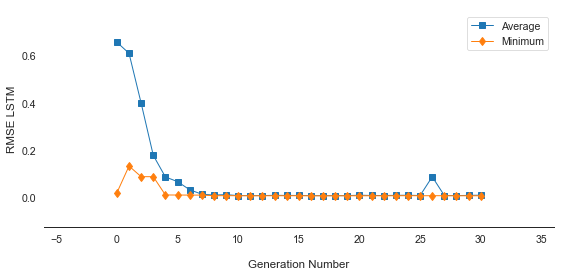

In [14]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.2)  

plt.figure(figsize=(8,4))
#avg1,min1,max1=scaler.inverse_transform([avg1,min1,max1])

plt.plot(gen1,avg1,marker='s',linewidth=1,markersize=6,label='Average')
plt.plot(gen1,min1,marker='d',linewidth=1,markersize=6,label='Minimum')
#plt.plot(gen1,max1,marker='*',linewidth=1,markersize=8,label='Maximum')
#plt.tick_params(left=False, labelleft=True)
#plt.box(False)
plt.margins(0.2)


plt.xlabel('Generation Number',labelpad=15)
plt.ylabel('RMSE LSTM')
#plt.xlim(-1, 26)
plt.legend(loc='best');
sns.despine(left=True)
plt.tight_layout()
plt.savefig('Fig1.png', bbox_inches='tight', dpi=400) 
plt.show()

In [ ]:
# Box Plot
a,b,c=log.select('min','max','std')

#a,b,c=scaler.inverse_transform([a,b,c])

df=pd.DataFrame({'Minimum':a,'Maximum':b, 'Std':c})

plt.figure(figsize=(6,4))
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  
sns.boxplot(data=df, width=0.6,color='#1f77b4')
plt.xlabel('Statistics across Generations and Particles',labelpad=15)
plt.ylabel('RMSE LSTM')
sns.despine(left=True)
plt.tight_layout()
plt.savefig('Fig1.png', bbox_inches='tight', dpi=400) 
plt.show()

### Save Results

In [15]:
a,b,c,d,e=log.select('gen','avg','min','max','std')

#b,c,d,e=scaler.inverse_transform([b,c,d,e])
df=pd.DataFrame({'Generation':a,'Average':b, 'Minimum':c,'Maximum':d,'Std':e})
writer = pd.ExcelWriter('GA_Final__norm.xlsx')
df.to_excel(writer,'Sheet1')
writer.save()

## Full Model

In [4]:
df1=df.copy(deep=True)
df1.head(2)

,Consumption
0,0.476205
1,0.479645


In [5]:
#Lags LSTM
lag1=np.arange(1,18,1)
lag2=np.arange(509,526,1)
lag3=np.arange(1003,1020,1)
lag=np.concatenate([lag1,lag2,lag3])
print('The number of lags are:',lag.shape)
lag

The number of lags are: (51,)


array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,  509,  510,  511,  512,  513,
        514,  515,  516,  517,  518,  519,  520,  521,  522,  523,  524,
        525, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019])

In [6]:
for col in df1.columns:
        for idx, l in enumerate(lag):
            df1.loc[:,col+"_"+str(idx)] = df1[col].shift(l)
           
df1.dropna(how='any',inplace=True)
dataset = df1.values # Converted dataframe to numpy ndarray
dataset = dataset.astype('float32')
print('New Dataset shape after Lags:',dataset.shape)

New Dataset shape after Lags: (156803, 52)


In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print('Training and test data length',len(train), len(test))
    
trainX=train[:,1:]
trainY=train[:,0]
testX=test[:,1:]
testY=test[:,0]
    
print('trainX.shape[0]: ',trainX.shape[0])
print('trainX shape:\n',trainX.shape)

Training and test data length 125442 31361
trainX.shape[0]:  125442
trainX shape:
 (125442, 51)


In [8]:
#LSTM
# reshape input to be [samples, time steps, features]
#trainX = np.reshape(trainX, (trainX.shape[0],window_length,(no_wins)))
#testX = np.reshape(testX, (testX.shape[0],window_length,(no_wins)))

trainX = np.reshape(trainX, (trainX.shape[0],17,3))
testX = np.reshape(testX, (testX.shape[0],17,3))


print('Train X shape after np.reshape',trainX.shape)
print('Test X shape after np.reshape',testX.shape)
print('Train Y Shape',trainY.shape)
print('Test Y Shape',testY.shape)

Train X shape after np.reshape (125442, 17, 3)
Test X shape after np.reshape (31361, 17, 3)
Train Y Shape (125442,)
Test Y Shape (31361,)


In [9]:
# create and fit the LSTM network
model = Sequential() # New Instance of Model Object
model.add(LSTM(60, input_shape=(17,3)))
model.add(Dense(100, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='Adam')

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
start = time.time()
hist =model.fit(trainX, trainY, epochs=120, shuffle=True,batch_size=125, validation_data=(testX, testY), 
                callbacks=[EarlyStopping(monitor='val_loss', patience=20)], verbose=1)

end = time.time()
# Training Phase
model.summary()

Instructions for updating:
Use tf.cast instead.
Train on 125442 samples, validate on 31361 samples
Epoch 1/120
125442/125442 [==============================] - 31s 247us/step - loss: 0.0033 - val_loss: 3.0076e-04
Epoch 2/120
125442/125442 [==============================] - 28s 220us/step - loss: 3.9085e-04 - val_loss: 2.7266e-04
Epoch 3/120
125442/125442 [==============================] - 28s 220us/step - loss: 3.4971e-04 - val_loss: 2.7059e-04
Epoch 4/120
125442/125442 [==============================] - 28s 220us/step - loss: 3.2310e-04 - val_loss: 3.1914e-04
Epoch 5/120
125442/125442 [==============================] - 28s 220us/step - loss: 2.8972e-04 - val_loss: 2.3260e-04
Epoch 6/120
125442/125442 [==============================] - 27s 219us/step - loss: 2.8970e-04 - val_loss: 3.5295e-04
Epoch 7/120
125442/125442 [==============================] - 28s 220us/step - loss: 2.8629e-04 - val_loss: 2.5629e-04
Epoch 8/120
125442/125442 [==============================] - 27s 219us/step - l

In [11]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [13]:
from sklearn.metrics import mean_absolute_error

In [14]:
# calculate root mean squared error
print('Mean Absolute Error Train:', mean_absolute_error(trainY[0], trainPredict[:,0]))

testScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score RMSE: %.2f RMSE' % (testScore))

from sklearn.metrics import mean_absolute_error
print('Mean Absolute Error Test:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Mean Squared Error Test:',np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))
#print('Mean Absolute Percentage Error:',MAPError(testY[0], testPredict[:,0]))

Mean Absolute Error Train: 242.16780533830598
Train Score RMSE: 323.49 RMSE
Mean Absolute Error Test: 240.9821425866052
Mean Squared Error Test: 321.2727546409887


In [17]:
trainY.shape, testY.shape

((1, 125442), (1, 31361))

In [22]:
(321.27/(np.mean(testY)))*100

0.6104836323543474